In [53]:
#for importing, formatting and data manipulation
import pandas as pd
import numpy as np
import glob
import datetime
#from time import time
#from datetime import datetime
#from datetime import timedelta
import tempfile
from qiime2 import Artifact
import zipfile
import yaml

#for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
#sns.set(style="whitegrid")
import plotly.express as px
%matplotlib inline
from IPython.display import display
from upsetplot import plot
#import pyupset as pyu
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()

#for statistical analyses
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from skbio.diversity import alpha_diversity
from skbio.stats.distance import permanova
from skbio import DistanceMatrix
from scipy.spatial.distance import cdist
from skbio.stats.composition import clr
from skbio.stats.composition import alr
from skbio.stats.composition import ilr
from skbio.diversity.alpha import chao1

## Import and format metadata from lab, and BBMP

### Import lab metadata

In [3]:
def load_df():
    
    filenames = glob.glob('/Users/Diana/Documents/escuela/phd/ch2/bb_data/20**/METADATA.txt')
    #load all metadata and concatenate them into one dataframe
    md = []
    for filename in filenames:
        df = pd.read_csv(filename, sep='\t')
        md.append(df)
        print (filename)
    
    md = pd.concat(md)
    
    #drop empty columns and rows
    md.dropna(how='all', axis=1, inplace=True) #empty cols
    md.dropna(how='all', inplace=True) #empty rows
    
    return md

In [7]:
md = load_df()

/Users/Diana/Documents/escuela/phd/ch2/bb_data/2014/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2022/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2015/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2017/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2019/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2021/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2020/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2018/METADATA.txt
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2016/METADATA.txt


#### Renumber dates

In [8]:
#create a dictionary for months
month_dic = {
    "Jan": 1,
    "Feb": 2,
    "Mar": 3,
    "Apr": 4,
    "May": 5,
    "Jun": 6,
    "Jul": 7,
    "Aug": 8,
    "Sep": 9,
    "Oct": 10,
    "Nov": 11,
    "Dec": 12
}
month_season = {
    "Jan": "Winter",
    "Feb": "Winter",
    "Mar": "Spring",
    "Apr": "Spring",
    "May": "Spring",
    "Jun": "Summer",
    "Jul": "Summer",
    "Aug": "Summer",
    "Sep": "Autumn",
    "Oct": "Autumn",
    "Nov": "Autumn",
    "Dec": "Winter"
}
depth_num = {
    "A": 1,
    "B": 5,
    "C": 10,
    "D": 60,
    "E": 30
}

In [9]:
#add month to a new column
md['month_name'] = md['date'].str.split('-').str[1]

#add month number
md['month']= md['month_name'].map(month_dic)

#add day number
md['day'] = md['date'].str.split('-').str[0]
md[["year", "month", "day"]] = md[["year", "month", "day"]].apply(pd.to_numeric)

#remove symbol for better handling of data
#md.rename(columns={"Week#": "Weekn"}, inplace=True)
#md.rename(columns={"Depth": "depth"}, inplace=True) #to match dfo

#change to int to remove decimals from date columns
md.year = md.year.apply(int)
md.depth = md.depth.apply(int)
md.weekn = md.weekn.apply(int)

#change to str to aggregate them into time_string to match dfos formatting of the date
md.year = md.year.apply(str)
md.month = md.month.apply(str)
md.day = md.day.apply(str)
#add leading zero to match date format in dfo metadata
md['month'] = md['month'].str.zfill(2)
md['day'] = md['day'].str.zfill(2)

#add leading zero to match date format in dfo metadata
md['month'] = md['month'].str.zfill(2)
md['day'] = md['day'].str.zfill(2)

md['time_string'] = md[['year', 'month', 'day']].agg('-'.join, axis=1)

### Import and manage BBMP data

#### Metadata __md__ is formatted. It contains 38 columns.
__md__ is the lab's metadata for sampling, extraction and sequencing. \
__dfo_md__ is BBMP remote sensing data (salinity, pH, temperature, density..) \
__bio_niskin__ is nutrient data \
Format __bio_niskin__ data to merge with __md__. __bio_niskin__ is 32 columns, including year, month, day, and depth. __dfo_md__ also has 32 columns, including year_time, month_time, day_time. To merge these data with __md__, we will change the time stamps columns to the same name, and generate a time_string column.

In [10]:
dfo_md = pd.read_csv("/Users/Diana/Documents/escuela/phd/ch2/bb_data/bbmp_aggregated_profiles.csv")
bio_niskin = pd.read_csv("/Users/Diana/Documents/escuela/phd/ch2/bb_data/BBMP_Data_2022.csv")#
#dfo_metadata_y14 = pd.read_csv("/Users/Diana/Documents/escuela/phd/bb_data/2019/data_export/trim-analysis/dfo_metadata_y14.tsv", sep='\t')

#change to str to aggregate them into time_string
bio_niskin.year = bio_niskin.year.apply(str)
bio_niskin.month = bio_niskin.month.apply(str)
bio_niskin.day = bio_niskin.day.apply(str)
#add leading zero to match date format in dfo metadata
bio_niskin['month'] = bio_niskin['month'].str.zfill(2)
bio_niskin['day'] = bio_niskin['day'].str.zfill(2)

bio_niskin['time_string'] = bio_niskin[['year', 'month', 'day']].agg('-'.join, axis=1)

#make a new column for time_string without the time
dfo_md['time_string_time'] = dfo_md['time_string']
dfo_md['time_string'] = dfo_md['time_string'].str.split(' ').str[0]

#renaming columns to ensure correct merging
dfo_md.rename(columns={"depth":"bbmpdepth","pressure": "depth", "year_time": "year", "month_time": "month", "day_time": "day"}, inplace=True)

#change to int to remove decimals from date columns
cols = ['year', 'depth', 'month', 'day']
md[cols] = md[cols].apply(pd.to_numeric, errors='ignore', axis=1)
dfo_md[cols] = dfo_md[cols].apply(pd.to_numeric, errors='ignore', axis=1)
bio_niskin[cols] = bio_niskin[cols].apply(pd.to_numeric, errors='ignore', axis=1)

#make a season column
md['season'] = ''

for month, season in month_season.items():
    md.loc[md['month_name'] == month, 'season'] = season

#merging party
merged = pd.merge(md, dfo_md, on=["year", "month", "depth", "day"], how="left")
allyears = pd.merge(md, dfo_md, on=["year", "month", "depth", "day"], how="outer")

#add nutrient data
preall_md= pd.merge(allyears, bio_niskin, on=["day", "month", "year", 'depth'], how="outer")
all_md = pd.merge(merged, bio_niskin, on=["day", "month", "year", 'depth'], how="left")

#split dfs by depth
shallow_depths = [1, 5, 10]
shallow = all_md[all_md["depth"] < 30]
#shallow = shallow.groupby(['year', 'month', "day"]).mean().reset_index()
deep = all_md[all_md.depth == 60]

#split dfs by season
year_season = preall_md.groupby(by = ['year','season']).mean().reset_index()

Winter = year_season.loc[year_season['season'] == 'Winter',:]
Spring = year_season.loc[year_season['season'] == 'Spring',:]
Summer = year_season.loc[year_season['season'] == 'Summer',:]
Autumn = year_season.loc[year_season['season'] == 'Autumn',:]

#save output as csv
all_md.to_csv('allmetadata.csv')

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_9919/2823838939.py:35: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged = pd.merge(md, dfo_md, on=["year", "month", "depth", "day"], how="left")
/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_9919/2823838939.py:36: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  allyears = pd.merge(md, dfo_md, on=["year", "month", "depth", "day"], how="outer")
/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_9919/2823838939.py:40: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  all_md = pd.merge(merged, bio_niskin, on=["day", "month", "year", 'depth'], how="left")
/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_9919/2823838939.py:49: FutureWarning: The default value of numeric_only in Dat

## Find missing data

In [7]:
emptynit = all_md[all_md['Nitrate'].isna()]

## Plotting party

In [37]:
#plotly seasonal averages figure
fig2 = go.Figure()
for template in ["plotly_white"]:
    fig2.add_trace(go.Scatter(x=Winter['year'], y=Winter['temperature'],
                    mode='lines',
                    name='Winter',
                    marker_color='#838B8B'))
    fig2.add_trace(go.Scatter(x=Spring['year'], y=Spring['temperature'],
                    mode='lines',
                    name='Spring',
                    marker_color='#FFB5C5'))
    fig2.add_trace(go.Scatter(x=Summer['year'], y=Summer['temperature'],
                    mode='lines',
                    name='Summer',
                    marker_color='#87CEFF'))
    fig2.add_trace(go.Scatter(x=Autumn['year'], y=Autumn['temperature'],
                    mode='lines',
                    name='Autumn',
                    marker_color='#FF8000'))
    fig2.update_layout(
    height=800,
    xaxis_title="Years",
    yaxis_title='Temperature in degree',
    title_text='Average Temperature seasonwise over the years',
    template=template)

fig2.show()

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



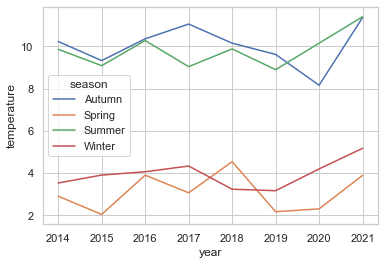

In [18]:
#seaborn season averages plot
sns.lineplot(year_season['year'],year_season['temperature'], hue =year_season["season"])

In [548]:
plt.style.use('ggplot')

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



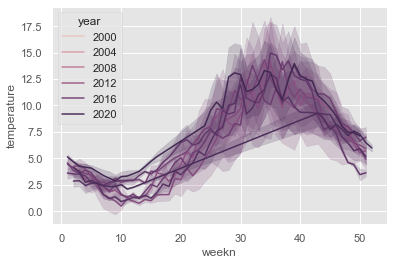

In [549]:
sns.lineplot(allin['weekn'],allin['temperature'], hue =allin["year"])

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



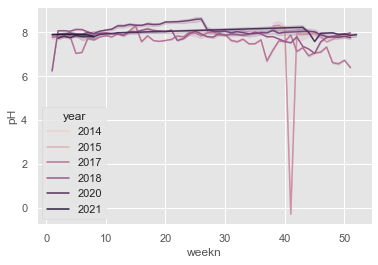

In [550]:
sns.lineplot(merged['weekn'],merged['pH'], hue =merged["year"])

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



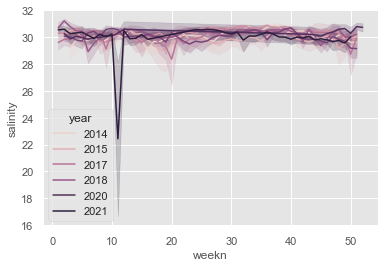

In [551]:
sns.lineplot(merged['weekn'],merged['salinity'], hue =merged["year"])

In [218]:
target_years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

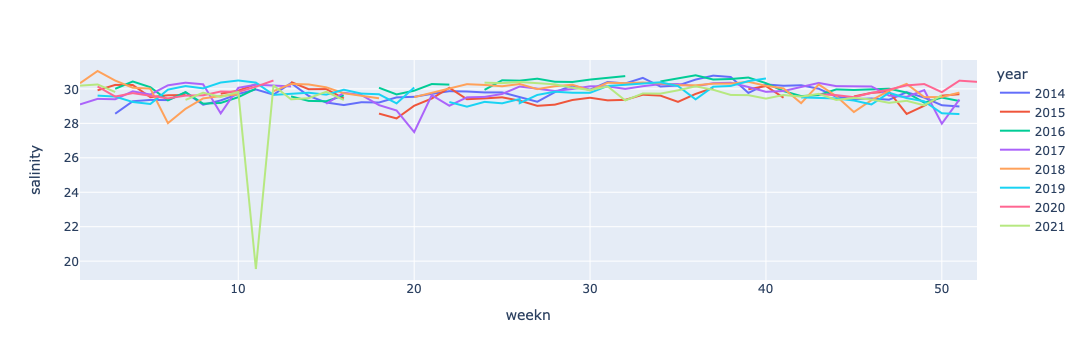

In [219]:
fig = px.line(shallow, x="weekn", y="salinity", color='year')
fig.show()

### Detect and plot anomalies in variables

In [11]:
def detect_anomalies(metadata, depth, yr=all, month=all):
    md_col = depth[['weekn', metadata, "year", "month"]].copy()
    md_col = md_col[md_col[metadata].notna()]
    if yr != all:
        #mdcol_yr = md_col[md_col.Year == yr]
        mdcol_yr = md_col[md_col['year'].isin(yr)]
    else: 
        mdcol_yr = md_col
        
    if month != all:
        #mdcol_yr = mdcol_yr[mdcol_yr.Month == month]
        mdcol_yr = mdcol_yr[mdcol_yr['month'].isin(month)]
    
    mdcol_yr = mdcol_yr.drop(columns=['year', "month"])
    mdcol_yr = mdcol_yr.set_index(['weekn'])
    
    #modelling time
    outliers_fraction = float(.01)
    scaler = StandardScaler()
    np_scaled = scaler.fit_transform(mdcol_yr.values.reshape(-1, 1))
    data = pd.DataFrame(np_scaled)
    # train isolation forest
    model =  IsolationForest(contamination=outliers_fraction)
    model.fit(data)
    
    #predict data
    mdcol_yr['anomaly'] = model.predict(data)
    
    
    # visualization
    fig, ax = plt.subplots(figsize=(10,6))
    a = mdcol_yr.loc[mdcol_yr['anomaly'] == -1, [metadata]] #anomaly
    ax.plot(mdcol_yr.index, mdcol_yr[metadata], color='black', label = 'Normal')
    ax.scatter(a.index,a[metadata], color='red', label = 'Anomaly')
    plt.axvline(36, ls='--')
    plt.legend()
    plt.show();
    #add axes names

In [18]:
shallow[shallow["year"] > 2014]

,sampleid,year,date,weekn,depth,depth_code,date_depth,[DNA]ng/uL,A260/280,extraction_date,extracted_by,Sequenced,IMR_n,elutin_volume,nifH,MetaG,new_id,notes,size_code,Tube Label BBYear.WeekDepthSize,Filtration Volume (DNA),Freezer Box (1.5mL),Notes,Date (BIO),Depth (CTD),Local Time,Salinity_x,Temperature_x,Oxygen,par_x,fluorometer_x,pH_x,theta_x,sigmaTheta_x,elution_volume,Unnamed: 15,16S V6V8\nIMR #,BR Working Code (Top of Tube),Label on side of Tube,H2O Vol Filtered,IMR # - V4V5,IMR # - 18S,Elution volume,Correct Week #,Sequencing Code\nBBYear.WeekDepthSize,Freezer Box,Aliquots,[DNA]ng/ul,sample_code,month_name,month,day,time_string_x,season,time_string_y,julian_day,scan,temperature,conductivity,oxygenVoltage,fluorescence,unknown,pH_y,PSAR,salinity,theta_y,sigmaTheta_y,oxygen,scan2,fluorescence2,turbidity,oxygenCurrent,oxygenTemperature,oxygenSaturation,unknown2,altimeter,sigmaTheta2,VOLT,bbmpdepth,fluorometer_y,par_y,flagArchaic,time_string_time,mission_descriptor,event_id,sample_id,latitude,longitude,time,Chlorophyll A,Nitrate,Nitrite,Phosphate,Silicate,Ammonia,Salinity_y,Temperature_y,HPLC_ALLOX,HPLC_BUT19,HPLC_CHLA,HPLC_CHLB,HPLC_CHLC12,HPLC_CHLC3,HPLC_DIADINOX,HPLC_DIATOX,HPLC_FUCOX,HPLC_HEX19,HPLC_PERID,HPLC_ZEA,POC,PON,time_string
196,BB22.1A,2022,07-Jan,1,1,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W,BB22.1A,490,NaN,NaN,2022-01-07,1.0,12:18:48 PM,28.7164,5.1020,6.5108,2.64220,0.6261,7.938,5.1019,22.6874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan,1,7,2022-01-07,Winter,2022-01-07,7.0,4185.0,5.1020,2.805173,3.0174,0.6261,NaN,7.938,2.64220,28.7164,5.1019,22.6874,7.2916,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-07 12:14:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,BB22.1B,2022,07-Jan,1,5,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W,BB22.1B,540,NaN,NaN,2022-01-07,5.0,12:18:56 PM,29.9009,5.3068,6.2755,0.34279,0.6528,7.927,5.3064,23.6030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan,1,7,2022-01-07,Winter,2022-01-07,7.0,4309.0,5.3068,2.926279,2.9864,0.6528,NaN,7.927,0.34279,29.9009,5.3064,23.6030,7.0280,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-07 12:14:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,BB22.1C,2022,07-Jan,1,10,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W,BB22.1C,520,NaN,NaN,2022-01-07,10.0,12:19:03 PM,30.0675,5.5890,6.0890,0.06392,0.3885,7.921,5.5883,23.7040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan,1,7,2022-01-07,Winter,2022-01-07,7.0,4421.0,5.5890,2.963744,2.9305,0.3885,NaN,7.921,0.06392,30.0675,5.5883,23.7040,6.8192,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-07 12:14:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201,BB22.2A,2022,12-Jan,2,1,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W,BB22.2A,530,NaN,NaN,2022-01-12,1.0,2:53:36 PM,28.6579,2.7423,6.9896,283.83000,6.1486,8.054,2.7423,22.8449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan,1,12,2022-01-12,Winter,2022-01-12,12.0,5189.0,2.7423,2.622341,3.0149,6.1486,NaN,8.054,283.83000,28.6579,2.7423,22.8449,7.8278,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-12 14:48:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202,BB22.2B,2022,12-Jan,2,5,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W,BB22.2B,550,NaN,NaN,2022-01-12,5.0,2:53:43 PM,29.2324,4.1350,6.5305,23.80500,7.1255,8.034,4.1347,23.1892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan,1,12,2022-01-12,Winter,2022-01-12,12.0,5307.0,4.1350,2.776443,3.0050,7.1255,NaN,8.034,23.80500,29.2324,4.1347,23.1892,7.3137,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-12 14:48:12,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [16]:
detect_anomalies('Phosphate', shallow, yr={2022}, month={1,2,3})

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by StandardScaler.

In [42]:
detect_anomalies('Phosphate', shallow, yr={2017}, month={7,8,9,10})

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by StandardScaler.

## Add prokaryotic community

In [224]:
files = glob.glob('/Users/Diana/Documents/escuela/phd/ch2/bb_data/20**/dada2_output_exported/feature-table.tsv')
def load_df(filenames):
    ftables = []
    for filename in filenames:
        df = pd.read_csv(filename, sep='\t', header=None)
        #df1 = df.iloc[1:]
        ftables.append(df)
    return ftables

In [225]:
#load all metadata and concatenate them into one dataframe
ftables = load_df(files)
ftables = pd.concat(ftables, axis=1)

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning:

Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,

In [23]:
# Special thanks to Alex Manuele https://github.com/alexmanuele
def consolidate_tables(year=all):
    if year == all:
        table_list = glob.glob('{0}/*/table.qza'.format('/Users/Diana/Documents/escuela/phd/size_fractions/BB22_size-fraction-comparison-analysed/to_transfer'))
        print("Found all yearly tables")
        
    else:
        table_list = glob.glob('{0}/'+year+'/dada2_output/table_filt_contam.qza'.format('/Users/Diana/Documents/escuela/phd/ch2/splitted_data'))
        print("Found all yearly tables")
        
    dataframes = []  
    for table_path in table_list:
        with tempfile.TemporaryDirectory() as tempdir:
            #load table, dump contents to tempdir
            table = Artifact.load(table_path)
            #Make sure the tables are all FeatureFrequency type
            assert str(table.type) == 'FeatureTable[Frequency]', "{0}: Expected FeatureTable[Frequency], got {1}".format(table_path, table.type)
            Artifact.extract(table_path, tempdir)
            #get the provenance form the tempdir and format it for DF
            prov = '{0}/{1}/provenance/'.format(tempdir, table.uuid)
            action = yaml.load(open("{0}action/action.yaml".format(prov), 'r'), Loader=yaml.BaseLoader)
            paramlist = action['action']['parameters']
            paramlist.append({'table_uuid': "{}".format(table.uuid)})
            paramdict = {}
            for record in paramlist:
                paramdict.update(record)

            # Get the data into a dataframe
              #Biom data
            df = table.view(pd.DataFrame).unstack().reset_index()
            df.columns = ['feature_id', 'sample_name', 'feature_frequency']
            df['table_uuid'] = ["{}".format(table.uuid)] * df.shape[0]
              #param data
            pdf = pd.DataFrame.from_records([paramdict])
              #merge params into main df
            df = df.merge(pdf, on='table_uuid')
            

            #I like having these columns as the last three. Makes it more readable
            cols = df.columns.tolist()
            reorder = ['sample_name', 'feature_id', 'feature_frequency']
            for val in reorder:
                cols.append(cols.pop(cols.index(val)))
            df = df[cols]
            df['table_path'] = [table_path] * df.shape[0]
            df['sample_name'] = df['sample_name'].str.replace('-', '.')
            dataframes.append(df)
            
            # Adding table_id, forward and reverse trim columns
            #df['table_id'] = str(table_path.split('/')[-3]) #add a table_id column
            #df['forward_trim'], df['reverse_trim'] = df['table_id'].str.split('R', 1).str
            #df['forward_trim'] = df['forward_trim'].map(lambda x: x.lstrip('F'))
            #df["forward_trim"] = pd.to_numeric(df["forward_trim"])
            #df["reverse_trim"] = pd.to_numeric(df["reverse_trim"])

    #Stick all the dataframes together
    #outputfile="merged_all_tables.tsv"
    df = pd.concat(dataframes)
    #df.to_csv(comm+'/merged_all_tables.tsv', sep='\t', index=False)
    print("Successfully saved all tables.")
    return df

In [24]:
def merge_metadata(df):
    #df = pd.read_csv('02-PROKs/'+'/merged_all_tables.tsv', sep='\t')

    tables = df[['sample_name', 'feature_id', 'feature_frequency']].copy()
    tables.rename(columns={'sample_name':'sampleid'}, inplace=True)

    all_md['sampleid'] = all_md['sampleid'].str.replace('_', '.')
    merged = pd.merge(tables,all_md, on='sampleid', how='left') #all_md is the metadata file
    merged = merged[merged.feature_frequency != 0]
    print('Set up metadata ...')
    
    #merged.to_csv(comm+'/merged_asvs_metadata.tsv', sep = '\t')
    print('Saved merged_asvs_metadata.tsv')
    
    return merged

In [25]:
def pick_metadata(merged, depth='all', size_fraction='both', year='all', R='all', F='all', txsubset = 'all'):
#make df of features/composition+run+comm

    depth = depth
    year = year
    size_fraction = size_fraction
    txsubset = txsubset
        
    files = glob.glob('{0}/*/class/*/data/taxonomy.tsv'.format('/Users/Diana/Documents/escuela/phd/size_fractions/BB22_size-fraction-comparison-analysed/to_transfer'))
    taxos = []
#    if not os.path.exists(path+composition):
#        os.mkdir(path+composition)
    for filename in files:
        tax = pd.read_csv(filename, sep='\t')
        taxos.append(tax)
        
    print('Appended all taxonomies to taxos')
    taxos = pd.concat(taxos)
    taxos = taxos.rename(columns={"Feature ID": "feature_id"}, errors="raise")
    taxos = taxos.drop_duplicates()

    separated = merged.merge(taxos, how='left', on='feature_id') #merged excludes features of frequency = 0
    separated = separated.drop_duplicates()
    
    if depth != 'all':
        separated = separated[separated["depth"] == depth]
    if size_fraction != 'both':
        separated = separated[separated["size_fraction"] == size_fraction]

    
    
    
    #separated['total'] = separated.groupby(['table_id','sample-id'])['feature_frequency'].transform('sum')
    #separated['ratio'] = separated['feature_frequency']/(separated['total'])
    #separated_taxonomies = separated.copy()
    
    #make a dictionary with keys for id-ing the taxon belonging to this sub-community
    #separated_dic = pd.Series(separated.Taxon.values,separated.feature_id.values).to_dict()
    print('Saved separated by metadata dataframe.')
    
    return separated

In [26]:
df = consolidate_tables(year=all)

Found all yearly tables
Successfully saved all tables.


In [27]:
df['sample_name'] = df['sample_name'].str.replace(r'\.S([1-9]|[1-9][0-9]|[1-9][0-9][0-9]).L001\.','', regex=True)

In [28]:
merged = merge_metadata(df)

Set up metadata ...
Saved merged_asvs_metadata.tsv


In [29]:
merged['year'] = 2022

In [30]:
merged["size_code"] = ''

In [31]:
merged["size_code"] = merged["sampleid"].str.extract(r'[1-9][0-9]?[A-E]([L-S])')
merged["size_code"] = merged["size_code"].fillna('W')
merged["depth_code"] = merged["sampleid"].str.extract(r'[1-9][0-9]?([A-E])')
merged['depth']= merged['depth_code'].map(depth_num)
merged["weekn"] = merged["sampleid"].str.extract(r'\.([1-9][0-9]?)[A-E]')
merged['weekn'] = pd.to_numeric(merged['weekn'])
merged['depth'] = pd.to_numeric(merged['depth'])
merged['date'] = merged.groupby('weekn', as_index=False)['date'].transform('first')

In [32]:
separated = pick_metadata(merged)

Appended all taxonomies to taxos
Saved separated by metadata dataframe.


In [46]:
copy_of = separated.copy()

In [47]:
copy_of[['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']] = copy_of['Taxon'].str.split('; ', expand=True)

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_9919/3522112641.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  res = sns.kdeplot(x=copy_of['weekn'], y=copy_of['feature_frequency'], color='blue',shade=True)


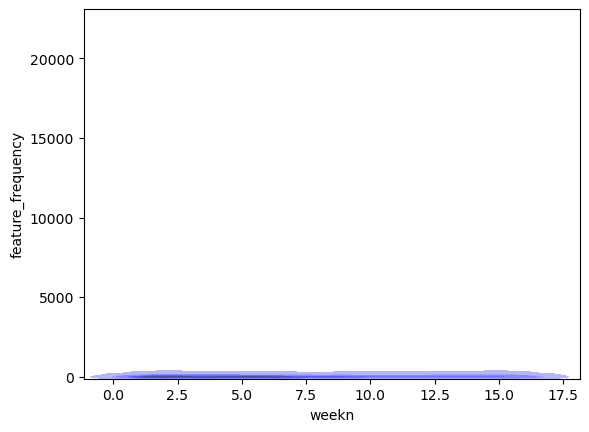

<Figure size 640x480 with 0 Axes>

In [38]:
res = sns.kdeplot(x=copy_of['weekn'], y=copy_of['feature_frequency'], color='blue',shade=True)
plt.show()
plt.savefig('kdeplot', format="svg")

In [48]:
copy_of.groupby('sampleid')['feature_id'].nunique()

sampleid
BB22.10A       5
BB22.10AL    160
BB22.10AS    289
BB22.10B     236
BB22.10BL     97
            ... 
BB22.9DL      85
BB22.9DS     652
BB22.9E      366
BB22.9EL     180
BB22.9ES     448
Name: feature_id, Length: 237, dtype: int64

In [40]:
#check for columns with missing values
copy_of.isnull().any()

sampleid             False
feature_id           False
feature_frequency    False
year                 False
date                 False
                     ...  
Class                 True
Order                 True
Family                True
Genus                 True
Species               True
Length: 123, dtype: bool

In [49]:
sfd1=copy_of[copy_of.depth==1]
sfd5=copy_of[copy_of.depth==5]
sfd10=copy_of[copy_of.depth==10]
sfd30=copy_of[copy_of.depth==30]
sfd60=copy_of[copy_of.depth==60]

In [42]:
copy_off = copy_of.copy()

In [43]:
copy_of=copy_of[copy_of.feature=='1ce3b5c6d85ce967f8677e23e3e9b0be']

In [44]:
sfd1p=copy_of[copy_of.depth==1]
sfd5p=copy_of[copy_of.depth==5]
sfd10p=copy_of[copy_of.depth==10]
sfd30p=copy_of[copy_of.depth==30]
sfd60p=copy_of[copy_of.depth==60]

In [58]:
sizecodes = ['S', 'L', 'W']
palette_colors = sns.color_palette()
palette_dict = {sizecode: color for sizecode, color in zip(sizecodes, palette_colors)}

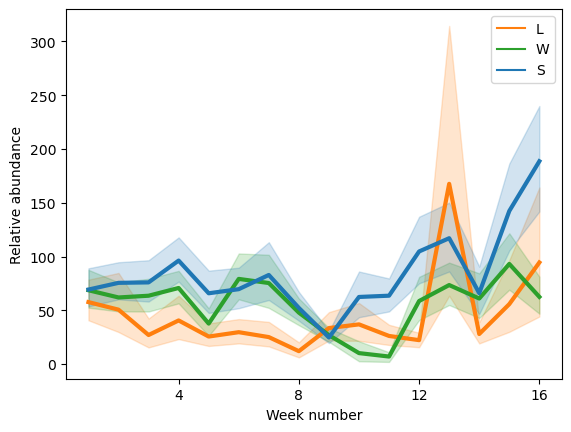

In [59]:
ax = sns.lineplot(data=sfd1, x ='weekn', y = 'feature_frequency',
                  hue='size_code', 
                  palette=palette_dict,
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Relative abundance')
plt.xlabel('Week number')
plt.show()

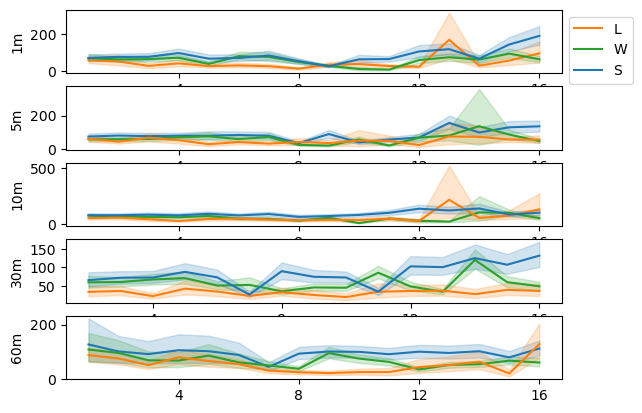

In [66]:
plt.subplot(511)
ax=sns.lineplot(x = "weekn", y = "feature_frequency", data=sfd1, hue="size_code", palette=palette_dict)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('1m')
plt.xlabel('')


plt.subplot(512)
ax1=sns.lineplot(x = "weekn", y = "feature_frequency", data=sfd5, hue="size_code", palette=palette_dict)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.ylabel('5m')
plt.xlabel('')
ax1.get_legend().remove()

plt.subplot(513)
ax2=sns.lineplot(x = "weekn", y = "feature_frequency", data=sfd10, hue="size_code", palette=palette_dict)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.ylabel('10m')
plt.xlabel('')
ax2.get_legend().remove()

plt.subplot(514)
ax3=sns.lineplot(x = "weekn", y = "feature_frequency", data=sfd30, hue="size_code", palette=palette_dict)
ax3.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.ylabel('30m')
plt.xlabel('')
ax3.get_legend().remove()


plt.subplot(515)
ax4=sns.lineplot(x = "weekn", y = "feature_frequency", data=sfd60, hue="size_code", palette=palette_dict)
ax4.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.ylabel('60m')
plt.xlabel('')
ax4.get_legend().remove()

plt.savefig('depth_profile_alltaxa.png')

In [134]:
toptaxa = sfd1[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth','weekn', 'Genus' ]].copy()
toptaxa = toptaxa.drop_duplicates()
df_agg = toptaxa.groupby(['size_code','Genus', 'depth']).agg({'feature_frequency':sum})
topd1 = df_agg['feature_frequency'].groupby('size_code', group_keys=False).nlargest(10)
topd1 = topd1.to_frame()
topd1 = topd1.reset_index()
topd1['set_name'] = topd1['size_code']+topd1['depth'].astype(str)

In [135]:
toptaxa = sfd5[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth','weekn', 'Genus' ]].copy()
toptaxa = toptaxa.drop_duplicates()
df_agg = toptaxa.groupby(['size_code','Genus', 'depth']).agg({'feature_frequency':sum})
topd5 = df_agg['feature_frequency'].groupby('size_code', group_keys=False).nlargest(10)
topd5 = topd5.to_frame()
topd5 = topd5.reset_index()
topd5['set_name'] = topd5['size_code']+topd5['depth'].astype(str)

In [136]:
toptaxa = sfd10[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth','weekn', 'Genus' ]].copy()
toptaxa = toptaxa.drop_duplicates()
df_agg = toptaxa.groupby(['size_code','Genus', 'depth']).agg({'feature_frequency':sum})
topd10 = df_agg['feature_frequency'].groupby('size_code', group_keys=False).nlargest(10)
topd10 = topd10.to_frame()
topd10 = topd10.reset_index()
topd10['set_name'] = topd10['size_code']+topd10['depth'].astype(str)

In [137]:
toptaxa = sfd30[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth','weekn', 'Genus' ]].copy()
toptaxa = toptaxa.drop_duplicates()
df_agg = toptaxa.groupby(['size_code','Genus', 'depth']).agg({'feature_frequency':sum})
topd30 = df_agg['feature_frequency'].groupby('size_code', group_keys=False).nlargest(10)
topd30 = topd30.to_frame()
topd30 = topd30.reset_index()
topd30['set_name'] = topd30['size_code']+topd30['depth'].astype(str)

In [138]:
toptaxa = sfd60[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth','weekn', 'Genus' ]].copy()
toptaxa = toptaxa.drop_duplicates()
df_agg = toptaxa.groupby(['size_code','Genus', 'depth']).agg({'feature_frequency':sum})
topd60 = df_agg['feature_frequency'].groupby('size_code', group_keys=False).nlargest(10)
topd60 = topd60.to_frame()
topd60 = topd60.reset_index()
topd60['set_name'] = topd60['size_code']+topd60['depth'].astype(str)

In [149]:
frames = topd1, topd5, topd10, topd30, topd60

In [157]:
frames = sfd1, sfd5, sfd10, sfd30, sfd60

In [156]:
sfd1['set_name'] = sfd1['size_code']+sfd1['depth'].astype(str)
sfd5['set_name'] = sfd5['size_code']+sfd5['depth'].astype(str)
sfd10['set_name'] = sfd10['size_code']+sfd10['depth'].astype(str)
sfd30['set_name'] = sfd30['size_code']+sfd30['depth'].astype(str)
sfd60['set_name'] = sfd60['size_code']+sfd60['depth'].astype(str)

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_9919/186233436.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfd1['set_name'] = sfd1['size_code']+sfd1['depth'].astype(str)
/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_9919/186233436.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfd5['set_name'] = sfd5['size_code']+sfd5['depth'].astype(str)
/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_9919/186233436.py:3: SettingWithCopyWarning: 
A value is trying to be set o

In [158]:
result = pd.concat(frames)

In [151]:
resultpivot = result.pivot_table(index='Phylum', columns='set_name', values='feature_frequency')

KeyError: 'Phylum'

In [142]:
resultpivot = resultpivot.fillna(0)

In [143]:
resultpivot[resultpivot != 0] = 1

In [144]:
resultpivot.to_csv('top10_genus_all16S.csv')

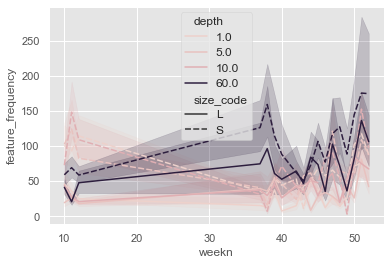

In [80]:
sns.lineplot(x = "weekn", y = "feature_frequency", data=y2020, hue="depth", style="size_code")
plt.show()

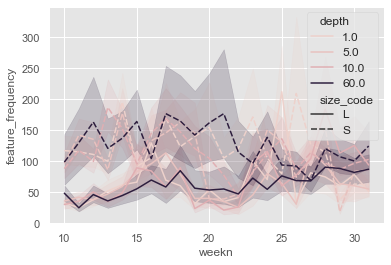

In [81]:
sns.lineplot(x = "weekn", y = "feature_frequency", data=y2021, hue="depth", style="size_code")
plt.show()

In [260]:
copy_of['feature_count'] = (
    copy_of.groupby(["sampleid"])['feature_id'].transform('nunique'))

In [261]:
plotadiv = copy_of[['sampleid', 'feature_count', 'year', 'weekn', 'size_code', 'depth']].copy()

In [84]:
sns.lineplot(x = "weekn", y = "feature_count", data=nonulladiv, style="year")
plt.show()

NameError: name 'nonulladiv' is not defined

In [262]:
null = plotadiv.loc[plotadiv['feature_count'] == 0]

In [263]:
null = null[['year','weekn','size_code','depth']].copy()

In [264]:
null = null.drop_duplicates()

In [265]:
null = null.reset_index(drop=True)

In [266]:
null.to_csv('missingsamples.csv', index=False)

In [267]:
notsizefractionated = plotadiv.loc[plotadiv['year'] < 2018]

In [268]:
sizefractionated = plotadiv.loc[plotadiv['year'] >= 2018]

In [269]:
nullnsf = notsizefractionated.loc[notsizefractionated['feature_count'] == 0]
nullnsf = nullnsf.drop_duplicates()

In [270]:
nullnsf

,sampleid,feature_count,year,weekn,size_code,depth
712495,BB14.47A,0,2014.0,47.0,NaN,1.0
712497,BB14.47B,0,2014.0,47.0,NaN,5.0
712499,BB17.28B,0,2017.0,28.0,NaN,5.0
713775,BB16.12A,0,2016.0,12.0,NaN,1.0
713776,BB16.12B,0,2016.0,12.0,NaN,5.0
713777,BB16.12C,0,2016.0,12.0,NaN,10.0
713778,BB16.12D,0,2016.0,12.0,NaN,60.0


In [271]:
nullsf = sizefractionated.loc[sizefractionated['feature_count'] == 0]
nullsf = nullsf.drop_duplicates()

In [637]:
nullsf

,sampleid,feature_count,year,weekn,size_code,depth
712501,BB19.2AL,0,2019.0,2.0,L,1.0
712503,BB19.2AS,0,2019.0,2.0,S,1.0
712505,BB19.2BL,0,2019.0,2.0,L,5.0
712507,BB19.2BS,0,2019.0,2.0,S,5.0
712509,BB19.2CL,0,2019.0,2.0,L,10.0
...,...,...,...,...,...,...
713765,BB18.51BS,0,2018.0,51.0,S,5.0
713767,BB18.51CL,0,2018.0,51.0,L,10.0
713769,BB18.51CS,0,2018.0,51.0,S,10.0
713771,BB18.51DL,0,2018.0,51.0,L,60.0


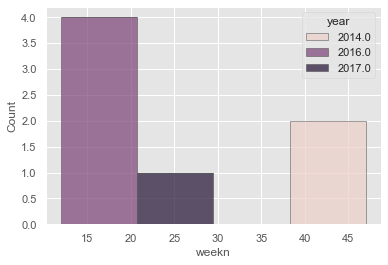

In [272]:
sns.histplot(
    nullnsf,
    x="weekn", hue="year",
    multiple="stack",
    #palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
)
plt.savefig('figures/missingsamplesNSF.png', format="png")

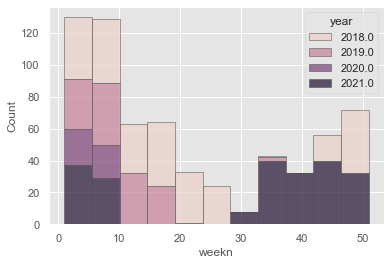

In [273]:
sns.histplot(
    nullsf,
    x="weekn", hue="year",
    multiple="stack",
    #palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
)
plt.savefig('figures/missingsamplesSF.png', format="png")

In [271]:
nonulladiv = plotadiv.loc[plotadiv['feature_count'] != 0]

In [180]:
allyears_aphotic = copy_of.loc[copy_of['depth'] == 60]

In [688]:
allyearsaphoSEP = allyears_aphotic.loc[allyears_aphotic['month'] == 9]

In [826]:
allshallow = copy_of.loc[copy_of['depth'] != 60]

In [827]:
allyearshallowSEP = allyearshallow.loc[allyearshallow['month'] == 9]

In [181]:
allyears = allyears_aphotic[['sampleid','feature_id','feature_frequency']].copy()

In [182]:
allyears = allyears.drop_duplicates()

In [183]:
allyears= allyears.pivot(index='sampleid', columns='feature_id', values='feature_frequency')

In [184]:
allyears=allyears.fillna(0)

In [693]:
allyears.rename(index={'BB10.20BL':'BB19.20BL'},inplace=True)

In [185]:
allyears.to_csv('deepdfs.csv', index_label='sampleid')

In [828]:
allyearshallow = allyearshallowSEP.copy()

In [751]:
allyearshallow.set_index('sampleid', inplace=True)

In [696]:
allyearshallow = allyearshallow.drop(columns=['feature_id', 'feature_frequency',
                                              'Taxon', 'Confidence', 'Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'])

In [752]:
allyearshallow = allyearshallow.drop_duplicates()

In [698]:
#some samples contain duplicates because two scans were done; groupby sample and keep mean
allyearshallow = allyearshallow.groupby(by=["sampleid"]).mean()

In [699]:
#forward fill missing values
allyearshallow = allyearshallow.fillna(method='ffill')

In [700]:
allyearshallow = allyearshallow.dropna(axis=1, how='all')

In [701]:
allyearshallow.rename(index={'BB10.20BL':'BB19.20BL'},inplace=True)

In [667]:
allyearshallow.to_csv('env_data_deep.csv', index_label='sampleid')

In [702]:
envindex = allyearshallow.index.tolist()

In [703]:
speindex = allyears.index.tolist()

In [704]:
temp3 = []
for element in envindex:
    if element not in speindex:
        temp3.append(element)
print(temp3)

[]


In [705]:
temp3 = []
for element in speindex:
    if element not in envindex:
        temp3.append(element)
print(temp3)

[]


In [829]:
allyearshallow["ratio_fid"] = allyearshallow["feature_frequency"] / allyearshallow["feature_count"]

In [830]:
allyearshallown19 = allyearshallow.loc[allyearshallow['year'] != 2019]

In [831]:
allyearshallow = allyearshallow[allyearshallow['ratio_fid'].notna()]

In [832]:
allyearshallow19 = allyearshallow.loc[allyearshallow['year'] == 2019]

In [833]:
allyearshallow19 = allyearshallow19[allyearshallow19['ratio_fid'].notna()]

In [834]:
top14 = allyearshallow.loc[allyearshallow['year'] == 2014]
top14 = top14.nlargest(5, "ratio_fid")

In [835]:
top15 = allyearshallow.loc[allyearshallow['year'] == 2015]
top15 = top15.nlargest(5, "ratio_fid")

In [836]:
top16 = allyearshallow.loc[allyearshallow['year'] == 2016]
top16 = top16.nlargest(5, "ratio_fid")

In [837]:
top17 = allyearshallow.loc[allyearshallow['year'] == 2017]
top17 = top17.nlargest(5, "ratio_fid")

In [838]:
top18 = allyearshallow.loc[allyearshallow['year'] == 2018]
top18 = top18.nlargest(5, "ratio_fid")

In [839]:
top19 = allyearshallow.loc[allyearshallow['year'] == 2019]
top19 = top19.nlargest(5, "ratio_fid")

In [840]:
top20 = allyearshallow.loc[allyearshallow['year'] == 2020]
top20 = top20.nlargest(5, "ratio_fid")

In [841]:
top21 = allyearshallow.loc[allyearshallow['year'] == 2021]
top21 = top21.nlargest(5, "ratio_fid")

In [842]:
result = pd.concat([top14, top15, top16, top17, top18, top19, top20, top21], axis=0)

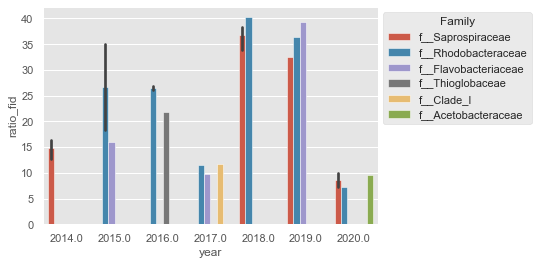

In [845]:
ax=sns.barplot(x = 'year', y = 'ratio_fid', hue = 'Family', data = result,
            edgecolor = 'w')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

In [186]:
allyearsclr=allyears.mask(allyears==0).fillna(0.1)

In [187]:
clr_transformed_array = clr(allyearsclr)

In [188]:
clr_transformed_array

array([[-0.86122616, -0.86122616, -0.86122616, ..., -0.86122616,
        -0.86122616, -0.86122616],
       [-0.25889084, -0.25889084, -0.25889084, ..., -0.25889084,
        -0.25889084, -0.25889084],
       [-0.94154829, -0.94154829, -0.94154829, ..., -0.94154829,
        -0.94154829, -0.94154829],
       ...,
       [ 1.76612349, -1.22960878, -1.22960878, ..., -1.22960878,
         3.55788296, -1.22960878],
       [-0.14404861, -0.14404861, -0.14404861, ..., -0.14404861,
        -0.14404861, -0.14404861],
       [ 2.1171759 , -1.28402148, -1.28402148, ..., -1.28402148,
         4.06308605, -1.28402148]])

In [189]:
samples = allyears.index
asvs = allyears.columns

In [190]:
#Creating the dataframe with the clr transformed data, and assigning the sample names
clr_transformed = pd.DataFrame(clr_transformed_array, columns=asvs)
#Assigning the asv names
clr_transformed['samples'] = samples
clr_transformed = clr_transformed.set_index('samples')
clr_transformed.head()

feature_id,0024026291e1a36a04810106884d6ce5,0044164f6d463942dca822a22c7c6f4d,004fddfa331355466f056bfd5ef0cae9,0089c2ee62e4e072faf4a080fc7ae6e5,008d11c0689fd62d7a19f9e1fbb54268,009cdbab8ec4e73afa9896e976ef4e79,00ab4eba45e1454a602ed070b0c793b1,00ddb6505f2f5ba73a19015855399f8f,00e047a89c3cc1d2d459545ac75f18ed,00f2a771e4a04d01f8d178357421ece7,0116b597b5e2459c2be3a40cf7cf0361,012054e3f62502aff7f455e1592ea87f,015600cdcdfdc7333d251c9c9160eb72,0164742d313437aa2650e7193b683326,01770ea2fb7f041c787e5a481888c27e,01874a5f6a88aa5196a4c6d1db4d910d,01893a6e745b291e28f8105c359b0f64,01b6055d816dfa26f1049780d85de084,01e3a10453a0f7cc6f327b8091090c58,01e72a13856e516d621ed099d6a38568,01e9f177991953b08628edc2cf4c3a0c,01eb34d864b5b8a54eb4fa9bac9a92ed,01eb8501fc1d31109052e5718cb5b392,01eb892495890df5ed35ff5ece71bfce,01efd728f0f0eafcff2ed38ab8e7afde,01ff566d25d0b8a42dbfe59acc6959cb,020446c8e46fe4351944e92c06ec5144,021829170463632e041095dab11c0e95,023afc3a991fd3d034caa37683e1b7c0,023c03872f74a964260494e8d6f3c3dc,02598367c3084826db395f6a326aa50f,025df27bf402908729e798b9a8eca1c8,027222412f4ad490a6291743c58999ab,028268ab77aff8e24e2d0935cbd0ad10,0293e7dd77aa94e17e4d7d07cf8a2049,0294f941b3b29cb483087d59457e5d89,02a866ccb1a98e57168e1b363ce2110d,02b7af11150741f6de128690c4aa3340,02c314f95ad067223b498b74861d0e26,02c67479243376747cb8f8f16cc1f8c6,02f128767d3d2d302454c4734f0dc2c2,0358a9f89b00722b6c7a4fc3f3b64ed3,035edd998d7864250c983102de197a9d,0361ef981e87152c6acf3dfc80d18bc3,03c7f0d6c3ba7e7723776208371f5ed0,03d2215b2efa460596cf9cec58880bd7,03d28d83f1b132a316b3701ae801d201,03e4bf667f0fcbb99b0563157ace1d8e,03e7efc17d402cebb0dc9dd6c6ec33af,03f391af11244396b4118d862f31e5ee,03f9b4536cfa51fc6adddc65b22bbfc8,0402b207354d165d39f034b30c944ef0,04100b84f03eceb0d2b20b796f362fc1,0413c184be9eaacc7504b510568a30d2,04168250d682cf34717296630d429c47,041d94aea96d4a1a29e06f366e37b86e,042f0c29cc88c4995aa24878559404bf,0434da6ac8b0cb6c7d0844ecf576cbee,045c0f99a190b3077144f5a67f78a464,045fc124b9d1cbb8ab61ec1b49c3eb7d,047bc5d9acd6864d3e7cbaf477d546ff,04890a82029a8c8614eb392e03fd7290,04a5fbaf45fdd7252cd9e341080587b1,04c35ed2cfcfbacb845262ac3b27770d,04d6572cbb0ba6f0d0e649371274f61b,04ed905d09939fb9f7a6fe5f2e8d706e,04ee9fe99860da57144ba42fa26c8e70,04f5c18fd5bd6486b3afa7374a05da41,05038205bfebc287e15534e5670b8b4a,053a38a4ce51cada6ad4a1511d070477,053f40d192f088eb3991dc116e53cf5e,05404c9fdf9f3f334eb618bac3f434f6,054f847ab1a5779d29d133d796ab55e1,05504fe332a95fe81917009c010616c9,058ba20bd286bb5d7d5dd5b406ec2629,06105df60508c2ed24a54f1b8ed64e49,061e80e54cd40e3b121f77bee4cbb770,06246cf1b40aae415d014d786d76a604,065f718c0519522661f2d3b088f3bdee,069a39be5f7a63d6e8272ff5fd5f2ac0,069c798abc5ea14b5fd5391f9968bc64,06a02c8a852b27651ddef23c4174e201,06d8763343503671a471c805c6056d50,06de7c18ee7acab2d757d1886b6422cd,070a3f1b60ce4c3305821fce27fc22ca,072e2acbe1fe8f687e8abba5cf8c5c57,0730e0fc0e591d133ee693c47ea4baee,073264e8c93a3016c046da55cb5108da,0739f02862c04e4e7c0d1847458e3760,075ae4ee7637c8107e88a0666b26c307,07684c39e9745c2660134a8a1eacfa03,076ee4c3aa52b3bb7b93cc3d51bb7775,0776c0b9236e65c35ddf556a273c7f27,07855a1c9eeb18068732835c1451049e,07a63464b81a078898e4e4b5ef93a0aa,07aaa77ecf15feb1425c3214f44f3695,07da7190c1fcdc3abf9e7406b8202f2b,07e4b29efc128015ffe3e0327d82d4b5,07f40fc12b7638fa614441311ab39fd0,07fdfda946aec86d936aff85695c11e2,080543f340e98a9c33cb1a1f388cc36f,080eb571e028e9df38cd8be945d8c883,081137d110528eb47e413d73a6e3b465,081481d983fe3aa1d6825bfbf5b45fd5,084d708e9413a6d72dd6d91ea3884e11,085108636a561ad2068b45ee0d4a31c6,086fd99658e3b363fe42e30d39a47d8f,087360e58d6a624e97294447849ec2cb,0888fd4eff999ec93d887377e96d689d,089d9f24709a4e0dff074b375835737e,08c464163652398eed7507828e953f3b,08d10673b70f3d8b078a149a25d94b19,08f5f418157b54ac9fabb19ab4048763,08ff326f613efe578c2e5e1999b305dc,0957415fe152e76765a4f8c69da48c48,095f506aff47f43e50e676e191eac1a4,0966a4fe83bbfbf5bc73bb2ebfe85735,09796dd558fe49c703a0265361fb5ee6,097977db7193b35be635ecfb9ef49f11,098bd3a79ae2dbeb5354d9034d47716b,098c3bbd8234f4ac198297ac0bde9

In [191]:
dist = cdist(clr_transformed, clr_transformed, 'euclid')

In [192]:
distance_matrix = pd.DataFrame(dist, columns=samples)

In [193]:
distance_matrix['samples'] = samples
distance_matrix = distance_matrix.set_index('samples')
distance_matrix

sampleid,BB22.10D,BB22.10DL,BB22.10DS,BB22.11D,BB22.11DL,BB22.11DS,BB22.12D,BB22.12DL,BB22.12DS,BB22.13D,BB22.13DL,BB22.13DS,BB22.14D,BB22.14DL,BB22.14DS,BB22.15D,BB22.15DL,BB22.15DS,BB22.16D,BB22.16DL,BB22.16DS,BB22.1D,BB22.1DL,BB22.1DS,BB22.2D,BB22.2DL,BB22.2DS,BB22.3D,BB22.3DL,BB22.3DS,BB22.4D,BB22.4DL,BB22.4DS,BB22.5D,BB22.5DL,BB22.5DS,BB22.6D,BB22.6DL,BB22.6DS,BB22.7D,BB22.7DL,BB22.7DS,BB22.8D,BB22.8DL,BB22.8DS,BB22.9D,BB22.9DL,BB22.9DS
samples,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BB22.10D,0.000000,99.755307,68.922825,64.065585,101.572636,70.916977,81.233715,104.092883,83.303374,79.963478,103.083077,79.157038,80.650781,104.345232,86.071786,80.957210,105.457161,82.824402,78.457976,117.827197,86.930087,116.348909,129.367888,113.346067,119.104077,130.015730,114.721339,114.386079,124.121803,121.039432,114.073777,129.302906,119.432821,115.301415,123.400118,113.646278,103.834615,126.207049,105.796118,83.898788,108.158615,84.154922,86.108734,106.578748,78.744523,81.492875,101.321877,84.134843
BB22.10DL,99.755307,0.000000,110.233841,93.183088,43.872707,111.588176,69.569843,57.139504,119.625257,88.749077,47.920289,113.940913,87.965091,60.720450,118.568660,98.474350,49.373542,93.731982,90.807633,90.130929,113.971733,97.059876,100.141072,94.757482,101.812029,99.988134,97.424220,94.981629,84.160620,101.444666,91.321595,98.104226,103.292796,98.622001,89.366385,96.613334,94.655562,93.184118,102.399789,89.687285,62.701345,80.854916,71.246074,51.209582,113.492385,120.143576,47.074840,122.917325
BB22.10DS,68.922825,110.233841,0.000000,70.863284,109.924988,69.000390,88.263803,114.537651,79.490196,85.390910,113.295006,76.911130,86.969702,115.577054,82.019297,86.502388,112.979578,84.565707,81.729051,127.893157,84.653623,119.936737,136.170210,115.911065,122.117532,136.925800,116.247637,118.515785,130.807185,123.242948,117.410233,136.014773,121.289571,118.734454,131.112259,116.619054,108.650426,134.682999,108.734925,84.450424,117.406607,84.093642,91.654802,115.708252,75.281619,77.213948,110.034888,81.256965
BB22.11D,64.065585,93.183088,70.863284,0.000000,92.679107,69.241651,70.942008,95.045221,83.242972,68.273172,93.863053,77.677441,69.767844,97.310987,82.903545,73.528464,97.390936,72.830406,69.416246,110.476169,82.570792,112.458451,126.046299,108.715838,114.969497,126.120325,109.941848,109.719178,118.743856,116.252965,109.412642,124.381932,115.685603,111.251448,119.908243,109.711172,101.056249,122.786198,104.450699,79.655179,102.613729,78.709675,78.905211,98.817645,82.692989,87.552134,94.683273,91.661006
BB22.11DL,101.572636,43.872707,109.924988,92.679107,0.000000,109.493753,65.493727,57.537249,118.444379,88.099497,42.166395,111.908363,87.158504,64.316615,117.383485,98.156106,35.472005,91.091442,89.346221,92.942973,112.435035,96.016284,101.055280,92.482008,101.016507,99.804948,95.046529,92.865351,82.049639,100.160347,89.333844,97.886914,101.441954,97.387211,88.992117,95.248370,93.622375,95.419702,101.834408,88.621543,64.413408,79.084862,66.521206,54.707233,113.687834,120.388135,38.479100,122.822142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BB22.8DL,106.578748,51.209582,115.708252,98.817645,54.707233,117.161141,77.174757,67.476511,124.694322,96.291263,59.854847,119.217467,96.029481,71.002379,124.168752,105.258298,59.302325,100.756459,97.049425,95.373159,119.049698,101.752304,103.847575,98.942584,105.562034,103.058044,101.640923,97.887998,87.829861,105.323492,95.904623,100.332536,107.143785,102.141807,93.615742,100.401128,98.157745,96.076610,105.596968,93.763803,64.345016,85.516659,76.528278,0.000000,118.414719,124.964195,55.729624,127.070737
BB22.8DS,78.744523,113.492385,75.281619,82.692989,113.687834,78.407538,95.516666,118.450547,89.170351,93.135410,116.672161,84.167845,93.951761,119.074355,90.156531,93.314151,116.941702,93.103147,90.864922,131.839818,94.543487,121.302863,137.099

In [194]:
dm = DistanceMatrix(distance_matrix)

In [195]:
permanova(dm, grouping=allyears_sc['size_code'])

ValueError: Grouping vector size must match the number of IDs in the distance matrix.

In [378]:
permanova(dm, grouping=allyearshallow['Nitrite'])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     147
number of groups                 39
test statistic              2.99059
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [198]:
from skbio.stats.composition import ancom

In [203]:
allyears_sc = allyears_aphotic[['sampleid','size_code']].copy()

In [204]:
allyears_sc = allyears_sc.drop_duplicates()

In [209]:
allyears_sc=allyears_sc.set_index('sampleid')

In [210]:
results = ancom(table=allyearsclr, grouping=allyears_sc['size_code'])

/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


In [211]:
prcentile = results[1].copy()

In [231]:
prcentile.iloc[:, prcentile.columns.get_level_values(1)=='W']

Percentile,0.0,25.0,50.0,75.0,100.0
Group,W,W,W,W,W
feature_id,,,,,
0024026291e1a36a04810106884d6ce5,0.1,0.1,0.1,0.100,2.0
0044164f6d463942dca822a22c7c6f4d,0.1,0.1,0.1,0.100,2.0
004fddfa331355466f056bfd5ef0cae9,0.1,0.1,0.1,0.100,6.0
0089c2ee62e4e072faf4a080fc7ae6e5,0.1,0.1,2.5,4.000,7.0
008d11c0689fd62d7a19f9e1fbb54268,0.1,0.1,0.1,0.825,8.0
...,...,...,...,...,...
ffb0f612bb069da34d387b1a853181f5,0.1,0.1,0.1,0.100,4.0
ffbd54eab7361aaf1a40762c62fabf95,0.1,0.1,0.1,0.100,2.0


In [237]:
idx = pd.IndexSlice
prcentile.loc[:,idx[:,'W'] == 0.1]

KeyError: 'False: boolean label can not be used without a boolean index'

In [238]:
prcentile.query('W == 0.1')

UndefinedVariableError: name 'W' is not defined

In [227]:
prcentile.loc[prcentile.index == '2997f1920aefbb91632b549f2538b73b']

Percentile,0.0,25.0,50.0,75.0,100.0,0.0,25.0,50.0,75.0,100.0,0.0,25.0,50.0,75.0,100.0
Group,L,L,L,L,L,S,S,S,S,S,W,W,W,W,W
feature_id,,,,,,,,,,,,,,,
2997f1920aefbb91632b549f2538b73b,0.1,0.1,0.1,0.1,13.0,24.0,42.0,82.5,188.25,233.0,5.0,36.75,62.0,71.25,204.0


In [212]:
DAresults = results[0].copy()

In [213]:
DARejected_year = DAresults.loc[DAresults['Reject null hypothesis'] == True]

In [214]:
DARejected_year.sort_values(by=['W'])

,W,Reject null hypothesis
feature_id,,
a404bf4d32831f2133794e5fe5d0a73e,2419,True
947eca43db88bfe1e67c4fb06e4d15a4,2430,True
7898ba618b82b7794566199b204eca07,2434,True
0bd2e49490c2c51a5094fef0a3ac86e7,2434,True
bcdb61c897d859cb4a79a74f2bb09683,2438,True
...,...,...
401a67858704d406087efd35334e84e1,2645,True
2997f1920aefbb91632b549f2538b73b,2661,True
1914aa84fc7f965e509b4302ae002c3e,2671,True


In [216]:
taxonomy = copy_of[['feature_id', 'Confidence', 'Taxon', 'Phylum', 'Class', 'Family', 'Genus', 'Species']].copy()

In [217]:
taxonomy = taxonomy.drop_duplicates()

In [218]:
DARejected_year_taxonomy = pd.merge(DARejected_year, taxonomy, on="feature_id", how="left")

In [219]:
DARejected_year_taxonomy.sort_values(by='W')

,feature_id,W,Reject null hypothesis,Confidence,Taxon,Phylum,Class,Family,Genus,Species
24,a404bf4d32831f2133794e5fe5d0a73e,2419,True,0.996628,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,p__Proteobacteria,c__Gammaproteobacteria,f__Thioglobaceae,g__SUP05_cluster,None
22,947eca43db88bfe1e67c4fb06e4d15a4,2430,True,0.775556,d__Bacteria; p__Nitrospinota; c__Nitrospinia; ...,p__Nitrospinota,c__Nitrospinia,f__Nitrospinaceae,g__LS-NOB,s__uncultured_delta
20,7898ba618b82b7794566199b204eca07,2434,True,0.932685,d__Bacteria; p__Proteobacteria; c__Alphaproteo...,p__Proteobacteria,c__Alphaproteobacteria,f__Magnetospiraceae,g__uncultured,s__uncultured_Alphaproteobacteria
1,0bd2e49490c2c51a5094fef0a3ac86e7,2434,True,0.884124,d__Bacteria; p__Proteobacteria; c__Alphaproteo...,p__Proteobacteria,c__Alphaproteobacteria,f__Clade_II,g__Clade_II,None
30,bcdb61c897d859cb4a79a74f2bb09683,2438,True,0.847876,d__Bacteria; p__Proteobacteria; c__Alphaproteo...,p__Proteobacteria,c__Alphaproteobacteria,f__Clade_II,g__Clade_II,None
...,...,...,...,...,...,...,...,...,...,...
11,401a67858704d406087efd35334e84e1,2645,True,0.997520,d__Bacteria; p__Proteobacteria; c__Alphaproteo...,p__Proteobacteria,c__Alphaproteobacteria,f__Clade_II,g__Clade_II,None
7,2997f1920aefbb91632b549f2538b73b,2661,True,0.984074,d__Bacteria; p__Proteobacteria; c__Alphaproteo...,p__Proteobacteria,c__Alphaproteobacteria,f__Clade_I,g__Clade_Ia,None
4,1914aa84fc7f965e509b4302ae002c3e,2671,True,0.999866,d__Archaea; p__Crenarchaeota; c__Nitrososphaer...,p__Crenarchaeota,c__Nitrososphaeria,f__Nitrosopumilaceae,g__Candidatus_Nitrosopumilus,None
15,54988ecf10dd5d89674a5517667bee14,2691,True,0.755651,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,p__Proteobacteria,c__Gammaproteobacteria,f__Methylophilaceae,g__OM43_clade,s__Methylophilales_bacterium


In [496]:
copy_of['avgNitrite'] = (
    copy_of.groupby(["weekn"])['Nitrite'].mean())

In [487]:
allyearshallow = allyearshallow.sort_values('sampleid')

In [488]:
allyearshallow['weektotaln'] = np.arange(allyearshallow.shape[0])

In [489]:
allyearshallow[ '4WksRollAv' ] = allyearshallow.Nitrite.rolling(4).mean()

In [ ]:
df[“Error”] = df[“Forecast”] — df[“Demand”]
m = df[“Error”].mean()
s = df[“Error”].std()
from scipy.stats import norm
limit_high = norm.ppf(0.99,m,s)+df[“Forecast”]
limit_low = norm.ppf(0.01,m,s)+df[“Forecast”]
df[“Updated”] = df[“Demand”].clip(lower=limit_low,upper=limit_high)
print(df)

In [718]:
preall_md_photic = preall_md.loc[preall_md['depth'] == 60]

In [734]:
nitriteonly = preall_md_photic[['weekn', 'year', 'Phosphate']].copy().drop_duplicates().dropna()

In [735]:
avgs = nitriteonly.groupby('weekn').mean()

In [736]:
avgs = avgs.drop(columns=['year'])

In [737]:
nitriteonly = nitriteonly.groupby(['weekn','year']).mean()

In [738]:
nitriteonly = nitriteonly.reset_index()

In [739]:
nitriteonly = pd.merge(nitriteonly, avgs, on="weekn")

In [740]:
nitriteonly

,weekn,year,Phosphate_x,Phosphate_y
0,1.0,2016,2.69500,2.970250
1,1.0,2017,3.22000,2.970250
2,1.0,2018,1.18000,2.970250
3,1.0,2021,4.78600,2.970250
4,2.0,2015,2.55750,2.324667
...,...,...,...,...
293,51.0,2015,2.76250,2.402362
294,51.0,2016,3.12167,2.402362
295,51.0,2017,1.39900,2.402362
296,51.0,2018,2.24750,2.402362


In [741]:
nitriteonly["Error"] = nitriteonly["Phosphate_y"]-nitriteonly["Phosphate_x"]

In [742]:
m = nitriteonly["Error"].mean()

In [743]:
s = nitriteonly["Error"].mean()

In [729]:
from scipy.stats import norm

In [744]:
limit_high = norm.ppf(0.99,m,s)+nitriteonly["Phosphate_y"]
limit_low = norm.ppf(0.01,m,s)+nitriteonly["Phosphate_y"]
nitriteonly["Updated"] = nitriteonly["Phosphate_x"].clip(lower=limit_low,upper=limit_high)
print(nitriteonly)

     weekn  year  Phosphate_x  Phosphate_y     Error  Updated
0      1.0  2016      2.69500     2.970250  0.275250      NaN
1      1.0  2017      3.22000     2.970250 -0.249750      NaN
2      1.0  2018      1.18000     2.970250  1.790250      NaN
3      1.0  2021      4.78600     2.970250 -1.815750      NaN
4      2.0  2015      2.55750     2.324667 -0.232833      NaN
..     ...   ...          ...          ...       ...      ...
293   51.0  2015      2.76250     2.402362 -0.360138      NaN
294   51.0  2016      3.12167     2.402362 -0.719308      NaN
295   51.0  2017      1.39900     2.402362  1.003362      NaN
296   51.0  2018      2.24750     2.402362  0.154862      NaN
297   51.0  2019      2.30350     2.402362  0.098862      NaN

[298 rows x 6 columns]


In [745]:
nitriteonly = nitriteonly.sort_values(["year", "weekn"]).reset_index()

In [746]:
nitriteonly = nitriteonly.reset_index()

In [686]:
nitriteonly.loc[nitriteonly['year'] == 2020]

,level_0,index,weekn,year,Nitrite_x,Nitrite_y,Error,Updated
282,282,8,2.0,2020,0.270000,0.333233,0.063233,0.331756
283,283,16,3.0,2020,0.295667,0.308435,0.012768,0.306958
284,284,24,4.0,2020,0.309500,0.317684,0.008184,0.316207
285,285,31,5.0,2020,0.269500,0.289983,0.020483,0.288506
286,286,39,6.0,2020,0.199000,0.275938,0.076938,0.274461
...,...,...,...,...,...,...,...,...
296,296,288,47.0,2020,0.219500,0.320167,0.100667,0.318690
297,297,296,48.0,2020,0.249750,0.308518,0.058768,0.307041
298,298,304,49.0,2020,0.251500,0.329386,0.077886,0.327909
299,299,318,51.0,2020,0.236000,0.347889,0.111889,0.346412


Text(0, 0.5, '[Phosphate]')

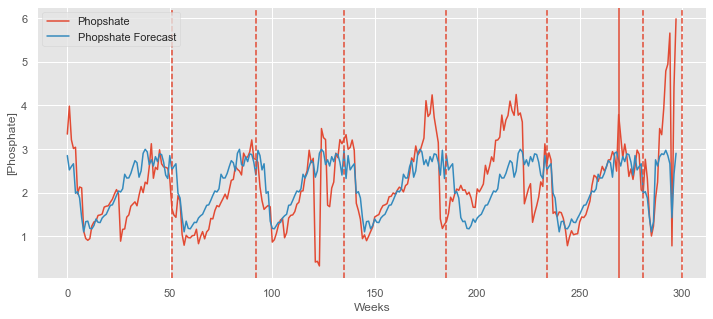

In [747]:
# set figure size
plt.figure( figsize = ( 12, 5))
  
# plot a simple time series plot
# using seaborn.lineplot()
sns.lineplot( x = 'level_0',
             y = 'Phosphate_x',
             data = nitriteonly,
             label = 'Phopshate')

sns.lineplot( x = 'level_0',
             y = 'Phosphate_y',
             data = nitriteonly,
             label = 'Phopshate Forecast')

plt.axvline(51, ls='--')
plt.axvline(92, ls='--')
plt.axvline(135, ls='--')
plt.axvline(185, ls='--')
plt.axvline(234, ls='--')
plt.axvline(269, ls='-')
plt.axvline(281, ls='--')
plt.axvline(300, ls='--')
  
plt.xlabel('Weeks')
plt.ylabel('[Phosphate]')

In [626]:
autoplot(tsclean(nitriteonly), series="clean", color='red', lwd=0.9)+
autolayer(nitriteonly, series="original", color='gray', lwd=1)+
geom_point(data = tsoutliers(nitriteonly) %>% as.data.frame(), aes(x='level_0', y='Nitrite_x'), col='blue')+labs(x = "Day", y = "Gold price ($US)")

SyntaxError: invalid syntax (<ipython-input-626-1009e8bf4a64>, line 1)

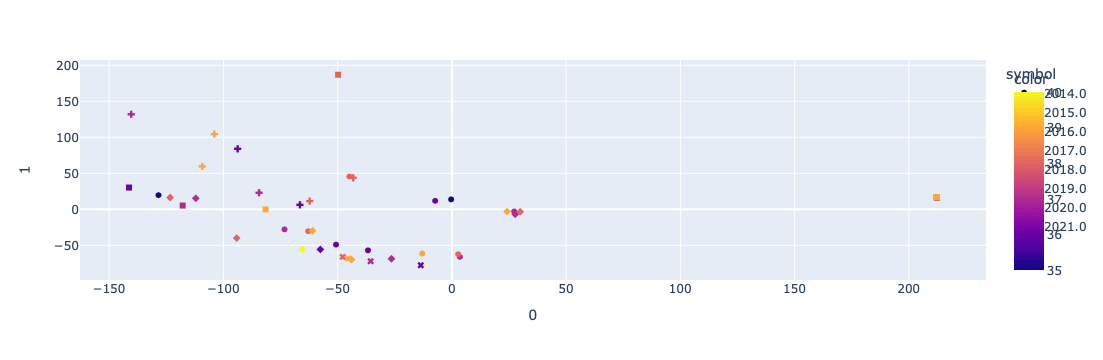

In [716]:
pca = PCA(n_components=2)
components = pca.fit_transform(distance_matrix)

fig = px.scatter(components, x=0, y=1, color=allyearshallow['weekn'], symbol=allyearshallow['year'])
fig.show()

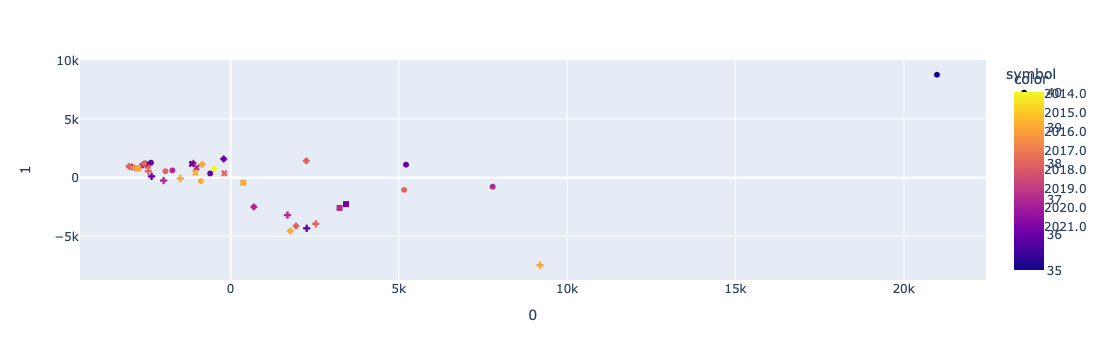

In [717]:
pca = PCA(n_components=2)
components = pca.fit_transform(allyears)

fig = px.scatter(components, x=0, y=1,color=allyearshallow['weekn'],symbol=allyearshallow['year'])
fig.show()

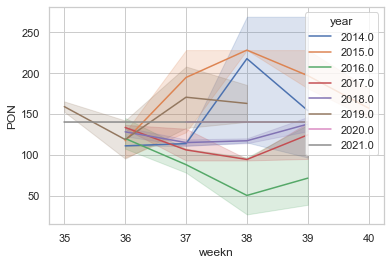

In [370]:
sns.lineplot(x = "weekn", y = "PON", data=allyearshallow, hue="year")
plt.show()

In [ ]:
grouped_data = sales_data.groupby('ProductID')
sales_data['AvgRevenuePerUnit'] = grouped_data['Revenue'].transform('mean') / grouped_data['Quantity'].transform('mean')

In [367]:
allyearshallow['year'] = pd.Categorical(allyearshallow['year'])

In [384]:
allyearshallow = allyearshallow.reset_index()

In [379]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(np.array(allyears))
plot_df = pd.DataFrame(data = principalComponents, columns = ['dim1', 'dim2'], index = allyears.index)

In [380]:
plot_df['dim1'] = plot_df['dim1']/1000
plot_df['dim2'] = plot_df['dim2']/1000

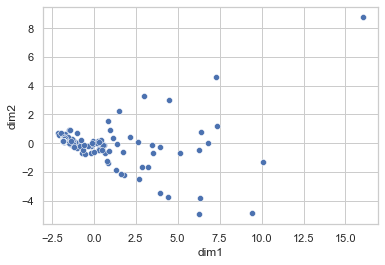

In [381]:
sns.scatterplot(x = 'dim1', y = 'dim2', data = plot_df)

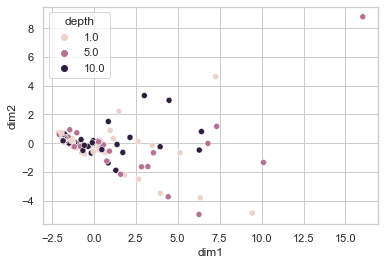

In [385]:
plot_df2 = pd.merge(plot_df,allyearshallow[['sampleid','depth']],on='sampleid', how='left')
sns.scatterplot(x = 'dim1', y = 'dim2', hue = 'depth', data = plot_df2)

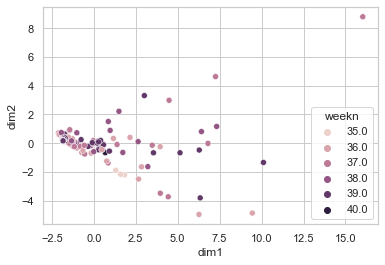

In [386]:
plot_df3 = pd.merge(plot_df,allyearshallow[['sampleid','weekn']],on='sampleid', how='left')
sns.scatterplot(x = 'dim1', y = 'dim2', hue = 'weekn', data = plot_df3)

In [387]:
from sklearn.manifold import TSNE
tsne = TSNE(metric = 'jaccard')
embeddings = tsne.fit_transform(allyears)
plot_df = pd.DataFrame(data = embeddings, columns = ['dim1', 'dim2'], index = allyears.index)

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1761: DataConversionWarning:

Data was converted to boolean for metric jaccard



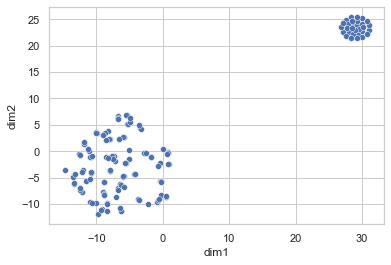

In [388]:
sns.scatterplot(x = 'dim1', y = 'dim2', data = plot_df)

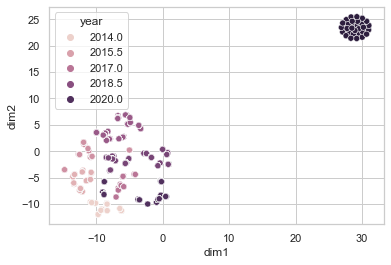

In [389]:
plot_df2 = pd.merge(plot_df,copy_of[['sampleid','year']],on='sampleid', how='left')
sns.scatterplot(x = 'dim1', y = 'dim2', hue = 'year', data = plot_df2)

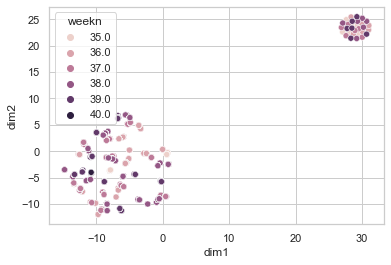

In [391]:
plot_df3 = pd.merge(plot_df,copy_of[['sampleid','weekn']],on='sampleid', how='left')
sns.scatterplot(x = 'dim1', y = 'dim2', hue = 'weekn', data = plot_df3)

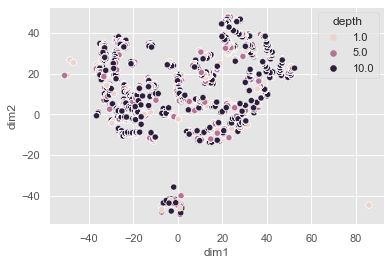

In [128]:
plot_df4 = pd.merge(plot_df,copy_of[['sampleid','depth']],on='sampleid', how='left')
sns.scatterplot(x = 'dim1', y = 'dim2', hue = 'depth', data = plot_df4)

In [132]:
conda install -c conda-forge umap-learn

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.7.4

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.4



## Package Plan ##

  environment location: /Users/Diana/miniconda3/envs/qiime2-2020.111

  added / updated specs:
    - umap-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2021.5.30          |   py36h79c6626_0         141 KB  conda-forge
    llvmlite-0.36.0            |   py36he4411ff_4         296 KB
    numba-0.53.1               |   py36hb2f4e1b_0         3.3 MB
    ope

In [137]:
import umap
reducer = umap.UMAP(n_components = 2, n_neighbors = 15, metric = 'jaccard', random_state = 0)
embeddings = reducer.fit_transform(allyears)
plot_df = pd.DataFrame(data = embeddings, columns = ['dim1', 'dim2'], index = allyears.index)

ContextualVersionConflict: (importlib-metadata 3.1.1 (/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages), Requirement.parse('importlib-metadata>=4.8.1; python_version < "3.8"'), {'pynndescent'})

In [294]:
copy_of

,sampleid,feature_id,feature_frequency,year,date,weekn,depth,depth_code,date_depth,[DNA]ng/uL,A260/280,extraction_date,extracted_by,Sequenced,IMR_n,elutin_volume,nifH,MetaG,new_id,notes,elution_volume,Unnamed: 15,16S V6V8\nIMR #,Notes,BR Working Code (Top of Tube),Label on side of Tube,H2O Vol Filtered,size_code,IMR # - V4V5,IMR # - 18S,Elution volume,Correct Week #,Sequencing Code\nBBYear.WeekDepthSize,Freezer Box,Aliquots,[DNA]ng/ul,Freezer Box (1.5mL),Filtration Volume (DNA),sample_code,month_name,month,day,time_string_x,time_string_y,julian_day,scan,temperature,conductivity,oxygenVoltage,fluorescence,unknown,pH,PSAR,salinity,theta,sigmaTheta,oxygen,scan2,fluorescence2,turbidity,oxygenCurrent,oxygenTemperature,oxygenSaturation,unknown2,altimeter,sigmaTheta2,VOLT,bbmpdepth,fluorometer,par,flagArchaic,time_string_time,season,mission_descriptor,event_id,sample_id,latitude,longitude,time,Chlorophyll A,Nitrate,Nitrite,Phosphate,Silicate,Ammonia,Salinity,Temperature,HPLC_ALLOX,HPLC_BUT19,HPLC_CHLA,HPLC_CHLB,HPLC_CHLC12,HPLC_CHLC3,HPLC_DIADINOX,HPLC_DIATOX,HPLC_FUCOX,HPLC_HEX19,HPLC_PERID,HPLC_ZEA,POC,PON,time_string,Taxon,Confidence,Domain,Phylum,Class,Order,Family,Genus,Species,feature_count
0,BB14.10A,6388564e4b25815b40d34be01eb2c574,102.0,2014.0,05-Mar,10.0,1.0,A,03.05.1m,4.5,1.97,May 6 2014,NaN,yes,NaN,100.0,NaN,NaN,BB14.10A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mar,3.0,5.0,2014-03-05,2014-03-05,64.0,1970.0,0.3580,0.581948,2.5917,2.8321,-0.065100,NaN,237.59000,29.3043,NaN,23.4968,7.61853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-05 13:29:16,Spring,18VA14667,9.0,387992.0,44.6917,-63.6417,1230.0,3.82000,7.810,0.2,0.7600,7.89,1.9800,29.3000,0.3600,0.0,0.0,3.904,0.135,0.717,0.0,0.45,0.0,1.878,0.0,0.0,0.0,NaN,NaN,2014-03-05,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.999999,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__NS9_marine_group,g__NS9_marine_group,None,202
1,BB14.10A,6388564e4b25815b40d34be01eb2c574,102.0,2014.0,05-Mar,10.0,1.0,A,03.05.1m,4.5,1.97,May 6 2014,NaN,yes,NaN,100.0,NaN,NaN,BB14.10A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mar,3.0,5.0,2014-03-05,2014-03-05,64.0,1906.0,0.3693,0.582096,2.5922,2.8311,0.045077,NaN,184.84000,29.3014,NaN,23.4940,7.61141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-05 13:29:16,Spring,18VA14667,9.0,387992.0,44.6917,-63.6417,1230.0,3.82000,7.810,0.2,0.7600,7.89,1.9800,29.3000,0.3600,0.0,0.0,3.904,0.135,0.717,0.0,0.45,0.0,1.878,0.0,0.0,0.0,NaN,NaN,2014-03-05,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.999999,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__NS9_marine_group,g__NS9_marine_group,None,202
2,BB14.10A,fd5eeee9dda082827512f461eae9139e,17.0,2014.0,05-Mar,10.0,1.0,A,03.05.1m,4.5,1.97,May 6 2014,NaN,yes,NaN,100.0,NaN,NaN,BB14.10A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mar,3.0,5.0,2014-03-05,2014-03-05,64.0,1970.0,0.3580,0.581948,2.5917,2.8321,-0.065100,NaN,237.59000,29.3043,NaN,23.4968,7.61853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-05 13:29:16,Spring,18VA14667,9.0,387992.0,44.6917,-63.6417,1230.0,3.82000,7.810,0.2,0.7600,7.89,1.9800,29.3000,0.3600,0.0,0.0,3.904,0.135,0.717,0.0,0.45,0.0,1.878,0.0,0.0,0.0,NaN,NaN,2014-03-05,d__Bacteria; p__Proteobacteria; c__Alphaproteo...,1.000000,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,None,None,202
3,BB14.10A,fd5eeee9dda082827512f461eae9139e,17.0,2014.0,05-Mar,10.0,1.0,A,03.05.1m,4.5,1.97,May 6 2014,NaN,yes,NaN,100.0,NaN,NaN,BB14.10A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mar,3.0,5.0,2014-03-05,2014-03-05,64.0,1906.0,0.3693,0.582096,2.5922,2.8311,0.045077,NaN,184.84000,29.3014,NaN,23.4940,7.61141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-05 13:29:16,Spring,18VA14667,9.0,387992.0,44.6917,-63.6417,123

In [312]:
y2014

,sampleid,feature_id,feature_frequency,year,date,weekn,depth,depth_code,date_depth,[DNA]ng/uL,A260/280,extraction_date,extracted_by,Sequenced,IMR_n,elutin_volume,nifH,MetaG,new_id,notes,elution_volume,Unnamed: 15,16S V6V8\nIMR #,Notes,BR Working Code (Top of Tube),Label on side of Tube,H2O Vol Filtered,size_code,IMR # - V4V5,IMR # - 18S,Elution volume,Correct Week #,Sequencing Code\nBBYear.WeekDepthSize,Freezer Box,Aliquots,[DNA]ng/ul,Freezer Box (1.5mL),Filtration Volume (DNA),sample_code,month_name,month,day,time_string_x,time_string_y,julian_day,scan,temperature,conductivity,oxygenVoltage,fluorescence,unknown,pH,PSAR,salinity,theta,sigmaTheta,oxygen,scan2,fluorescence2,turbidity,oxygenCurrent,oxygenTemperature,oxygenSaturation,unknown2,altimeter,sigmaTheta2,VOLT,bbmpdepth,fluorometer,par,flagArchaic,time_string_time,season,mission_descriptor,event_id,sample_id,latitude,longitude,time,Chlorophyll A,Nitrate,Nitrite,Phosphate,Silicate,Ammonia,Salinity,Temperature,HPLC_ALLOX,HPLC_BUT19,HPLC_CHLA,HPLC_CHLB,HPLC_CHLC12,HPLC_CHLC3,HPLC_DIADINOX,HPLC_DIATOX,HPLC_FUCOX,HPLC_HEX19,HPLC_PERID,HPLC_ZEA,POC,PON,time_string,Taxon,Confidence,Domain,Phylum,Class,Order,Family,Genus,Species
0,BB14.10A,6388564e4b25815b40d34be01eb2c574,102.0,2014.0,05-Mar,10.0,1.0,A,03.05.1m,4.5,1.97,May 6 2014,NaN,yes,NaN,100.0,NaN,NaN,BB14.10A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mar,3.0,5.0,2014-03-05,2014-03-05,64.0,1970.0,0.3580,0.581948,2.5917,2.8321,-0.065100,NaN,237.59000,29.3043,NaN,23.4968,7.61853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-05 13:29:16,Spring,18VA14667,9.0,387992.0,44.6917,-63.6417,1230.0,3.82,7.81,0.20,0.76,7.89,1.98,29.30,0.36,0.000,0.0,3.904,0.135,0.717,0.0,0.45,0.0,1.878,0.0,0.0,0.0,NaN,NaN,2014-03-05,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.999999,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__NS9_marine_group,g__NS9_marine_group,None
1,BB14.10A,6388564e4b25815b40d34be01eb2c574,102.0,2014.0,05-Mar,10.0,1.0,A,03.05.1m,4.5,1.97,May 6 2014,NaN,yes,NaN,100.0,NaN,NaN,BB14.10A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mar,3.0,5.0,2014-03-05,2014-03-05,64.0,1906.0,0.3693,0.582096,2.5922,2.8311,0.045077,NaN,184.84000,29.3014,NaN,23.4940,7.61141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-05 13:29:16,Spring,18VA14667,9.0,387992.0,44.6917,-63.6417,1230.0,3.82,7.81,0.20,0.76,7.89,1.98,29.30,0.36,0.000,0.0,3.904,0.135,0.717,0.0,0.45,0.0,1.878,0.0,0.0,0.0,NaN,NaN,2014-03-05,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.999999,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__NS9_marine_group,g__NS9_marine_group,None
2,BB14.10A,fd5eeee9dda082827512f461eae9139e,17.0,2014.0,05-Mar,10.0,1.0,A,03.05.1m,4.5,1.97,May 6 2014,NaN,yes,NaN,100.0,NaN,NaN,BB14.10A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mar,3.0,5.0,2014-03-05,2014-03-05,64.0,1970.0,0.3580,0.581948,2.5917,2.8321,-0.065100,NaN,237.59000,29.3043,NaN,23.4968,7.61853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-05 13:29:16,Spring,18VA14667,9.0,387992.0,44.6917,-63.6417,1230.0,3.82,7.81,0.20,0.76,7.89,1.98,29.30,0.36,0.000,0.0,3.904,0.135,0.717,0.0,0.45,0.0,1.878,0.0,0.0,0.0,NaN,NaN,2014-03-05,d__Bacteria; p__Proteobacteria; c__Alphaproteo...,1.000000,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,None,None
3,BB14.10A,fd5eeee9dda082827512f461eae9139e,17.0,2014.0,05-Mar,10.0,1.0,A,03.05.1m,4.5,1.97,May 6 2014,NaN,yes,NaN,100.0,NaN,NaN,BB14.10A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mar,3.0,5.0,2014-03-05,2014-03-05,64.0,1906.0,0.3693,0.582096,2.5922,2.8311,0.045077,NaN,184.84000,29.3014,NaN,23.4940,7.61141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-05 13:29:16,Spring,18VA14667,9.0,387992.0,44.6917,-63.6417,1230.0,3.82,7.81,0.20,0.76,7.89,1.98,29.30,0.36,0.000,0.

In [375]:
onlyphyl = copy_of.filter(['year','Phylum','season'], axis=1)

In [376]:
onlyphyl=onlyphyl.drop_duplicates()

In [377]:
onlyphyl.pivot(index='Phylum', columns='season'

SyntaxError: unexpected EOF while parsing (<ipython-input-377-7f2b9cfc1949>, line 1)

In [378]:
forupset=onlyphyl.groupby(['season', 'Phylum']).count().unstack().fillna(0)

In [379]:
forupset.where(forupset <= 1, 1, inplace=True)

In [380]:
forupset.to_csv('upsetplots.csv', index_label='weekn')

In [381]:
forupset

year                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
Phylum p__Acidobacteriota p__Actinobacteriota p__Armatimonadota p__Bacteroidota p__Bdellovibrionota p__Calditrichota p__Campilobacterota p__Cercozoa p__Chloroflexi p__Chlorophyta p__Ciliophora p__Cloacimonadota p__Crenarchaeota p__Cryptomycota p__Cryptophyceae p__Cyanobacteria p__Dadabacteria p__Deinococcota p__Dependentiae p__Desulfobacterota p__Diatomea p__Fermentibacterota p__Fibrobacterota p__Firmicutes p__Fusobacteriota p__Gemmatimonadota p__Halobacterota p__Hydrogenedentes p__Incertae_Sedis p__Kathablepharidae p__LCP-89 p__Latescibacterota p__Margulisbacteria p__Marinimicrobia_(SAR406_clade) p__Modulibacteria p__Myxococcota p__NB1-j p__Nanoarchaeota p__Nitrospinota p__Nitrospirota p__PAUC34f p__Patescibacteria p__Planctomycetota p__Protalveolata p__Proteobacteria p__SAR324_clade(Marine_group_B) p__Spirochaetota p__Sva0485 p__Synergistota p__Thermoplasmatota p__Verrucomicrobiota p__WPS-2
season                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
Autumn                1.0                 1.0               1.0             1.0                 1.0              1.0                 1.0         0.0            1.0            1.0           1.0               1.0              1.0             0.0              1.0              1.0             1.0             0.0             1.0                 1.0         0.0                  1.0               1.0           1.0               1.0                1.0              0.0                1.0               0.0                 1.0       1.0                 1.0                 1.0                              1.0               1.0            1.0      1.0              1.0             1.0             1.0        1.0                1.0                1.0              0.0               1.0                             1.0              1.0        1.0             1.0                 1.0                  1.0      1.0
Spring                1.0                 1.0               1.0             1.0                 1.0              0.0                 1.0         0.0            1.0            1.0           1.0               1.0              1.0             0.0              1.0              1.0             1.0             1.0             1.0                 1.0         1.0                  1.0               1.0 

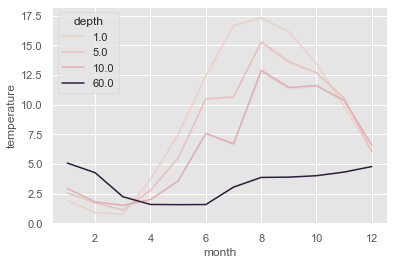

In [310]:
sns.lineplot(data=y2014, x="month", y="temperature", hue="depth")

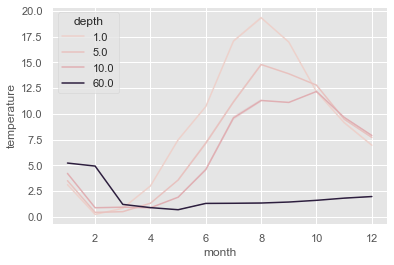

In [306]:
sns.lineplot(data=y2015, x="month", y="temperature", hue="depth")

In [311]:
salinity = shallow[['Weekn', 'temperature', "Year"]].copy()

In [313]:
salinity = salinity[salinity['temperature'].notna()]

In [314]:
salinity2014 = salinity[salinity.Year == 2019]
salinity2014 = salinity2014.drop(columns=['Year'])
salinity2014 = salinity2014.set_index(['Weekn'])

In [315]:
outliers_fraction = float(.01)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(salinity2014.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)

IsolationForest(contamination=0.01)

In [316]:
salinity2014

,temperature
Weekn,
2.0,2.151417
3.0,2.205233
4.0,1.592067
5.0,1.875233
6.0,1.943050
...,...
47.0,8.668567
48.0,7.817367
49.0,6.801833


In [317]:
salinity2014['anomaly'] = model.predict(data)

KeyError: "None of [Index(['salinity'], dtype='object')] are in the [columns]"

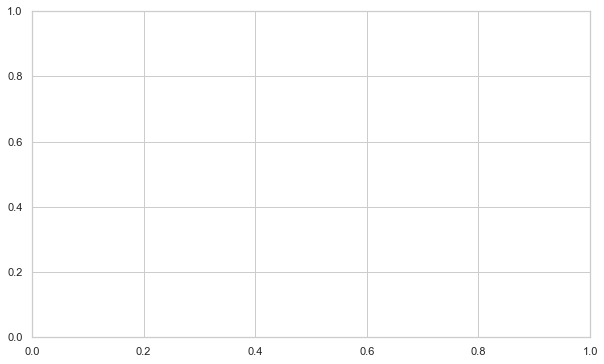

In [318]:
# visualization
fig, ax = plt.subplots(figsize=(10,6))
a = salinity2014.loc[salinity2014['anomaly'] == -1, ['salinity']] #anomaly
ax.plot(salinity2014.index, salinity2014['salinity'], color='black', label = 'Normal')
ax.scatter(a.index,a['salinity'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

In [253]:
fig = px.line(deep, x="Weekn", y="salinity", color='Year')
fig.show()

In [254]:
fig = px.line(deep, x="Weekn", y="Nitrate", color='Year')
fig.show()

In [38]:
all_md

,sampleid,Year,Date,Weekn,Depth,Depth_Code,Sample date,[DNA] (ng/uL),260/280,Extraction Date,...,HPLC_CHLC12,HPLC_CHLC3,HPLC_DIADINOX,HPLC_DIATOX,HPLC_FUCOX,HPLC_HEX19,HPLC_PERID,HPLC_ZEA,POC,PON
0,BB14.3A,2014,15-Jan,3,1,A,01.15.1m,NaN,NaN,NaN,...,0.000,0.0,0.0,0.0,0.129,0.0,0.0,0.0,NaN,NaN
1,BB14.3B,2014,15-Jan,3,5,B,01.15.5m,NaN,NaN,NaN,...,0.023,0.0,0.0,0.0,0.145,0.0,0.0,0.0,206.1,27.2
2,BB14.3C,2014,15-Jan,3,10,C,01.15.10m,NaN,NaN,NaN,...,0.042,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,NaN
3,BB14.3D,2014,15-Jan,3,60,D,01.15.60m,NaN,NaN,NaN,...,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,514.8,75.3
4,BB14.4A,2014,23-Jan,4,1,A,01.23.1m,NaN,NaN,NaN,...,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2223,BB16.50D,2016,14-Dec,50,60,D,NaN,11.6,NaN,2017-01-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2224,BB16.51A,2016,21-Dec,51,1,A,NaN,14.3,NaN,2017-01-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2225,BB16.51B,2016,21-Dec,51,5,B,NaN,11.2,NaN,2017-01-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2226,BB16.51C,2016,21-Dec,51,10,C,NaN,28.8,NaN,2017-03-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
print(all_md['month'].to_string(index=False))

  01
  01
  01
  01
  01
  01
  01
  01
  01
  01
  01
  01
  02
  02
  02
  02
  02
  02
  02
  02
  02
  02
  02
  02
  02
  02
  02
  02
  03
  03
  03
  03
  03
  03
  03
  03
  03
  03
  03
  03
  03
  03
  03
  03
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  04
  05
  05
  05
  05
  05
  05
  05
  05
  05
  05
  05
  05
  05
  05
  05
  05
  06
  06
  06
  06
  06
  06
  06
  06
  06
  06
  06
  06
  06
  06
  06
  06
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  07
  08
  08
  08
  08
  08
  08
  08
  08
  08
  08
  08
  08
  08
  08
  08
  08
  09
  09
  09
  09
  09
  09
  09
  09
  09
  09
  09
  09
  09
  09
  09
  09
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  10
  11
  11
  11
  11
  11
  11
  11
  11
  11
  11
  11
  11
  11
  11
  11
  11
  12
  12
  12
  12
  12
  12
  12
  12
  12
  12
  12
  12
 NaN
 NaN
 NaN
 NaN


In [31]:
all_md

,sampleid,Year,Date,Weekn,Depth,Depth_Code,Sample date,[DNA] (ng/uL),260/280,Extraction Date,...,HPLC_CHLC12,HPLC_CHLC3,HPLC_DIADINOX,HPLC_DIATOX,HPLC_FUCOX,HPLC_HEX19,HPLC_PERID,HPLC_ZEA,POC,PON
0,BB14.3A,2014,15-Jan,3,1,A,01.15.1m,NaN,NaN,NaN,...,0.000,0.0,0.0,0.0,0.129,0.0,0.0,0.0,NaN,NaN
1,BB14.3B,2014,15-Jan,3,5,B,01.15.5m,NaN,NaN,NaN,...,0.023,0.0,0.0,0.0,0.145,0.0,0.0,0.0,206.1,27.2
2,BB14.3C,2014,15-Jan,3,10,C,01.15.10m,NaN,NaN,NaN,...,0.042,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,NaN
3,BB14.3D,2014,15-Jan,3,60,D,01.15.60m,NaN,NaN,NaN,...,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,514.8,75.3
4,BB14.4A,2014,23-Jan,4,1,A,01.23.1m,NaN,NaN,NaN,...,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2223,BB16.50D,2016,14-Dec,50,60,D,NaN,11.6,NaN,2017-01-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2224,BB16.51A,2016,21-Dec,51,1,A,NaN,14.3,NaN,2017-01-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2225,BB16.51B,2016,21-Dec,51,5,B,NaN,11.2,NaN,2017-01-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2226,BB16.51C,2016,21-Dec,51,10,C,NaN,28.8,NaN,2017-03-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
all_md.Year.unique()

array(['2014', '2015', '2017', '2019', '2021', '2020', '2018', '2016'],
      dtype=object)

In [ ]:
fig = px.line(depth1, x="Weekn", y="temperature", color='Year', )
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [103]:
for index, row in dfo_md.iterrows():
    dfo_md['week_n'] = datetime.date(dfo_md['year_time'], dfo_md['month_time'], dfo_md['day_time']).isocalendar()[1]

,time_string,year_time,month_time,day_time,julian_day,scan,pressure,temperature,conductivity,oxygenVoltage,...,oxygenSaturation,unknown2,altimeter,sigmaTheta2,VOLT,depth,fluorometer,par,flagArchaic,week_n
0,1999-05-05 12:48:21,1999,5,5,125,2623.0,1.0,7.7017,NaN,NaN,...,NaN,0.17271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24
1,1999-05-05 12:48:21,1999,5,5,125,2629.0,1.5,7.3615,NaN,NaN,...,NaN,0.00506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24
2,1999-05-05 12:48:21,1999,5,5,125,2635.0,2.0,7.2588,NaN,NaN,...,NaN,0.03027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24
3,1999-05-05 12:48:21,1999,5,5,125,2640.0,2.5,6.5228,NaN,NaN,...,NaN,0.11686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24
4,1999-05-05 12:48:21,1999,5,5,125,2644.0,3.0,5.3546,NaN,NaN,...,NaN,0.15878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170924,2023-05-24 11:57:12,2023,5,24,144,14241.0,69.0,3.2369,2.851717,1.8235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24
170925,2023-05-24 11:57:12,2023,5,24,144,14266.0,69.5,3.2371,2.851766,1.8173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24
170926,2023-05-24 11:57:12,2023,5,24,144,14291.0,70.0,3.2371,2.851796,1.8138,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24
170927,2023-05-24 11:57:12,2023,5,24,144,14316.0,70.5,3.2373,2.851825,1.8109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24


In [58]:
df

,sepal_length,sepal_width,petal_length,petal_width,species,species_id
0,5.1,3.5,1.4,0.2,setosa,1
1,4.9,3.0,1.4,0.2,setosa,1
2,4.7,3.2,1.3,0.2,setosa,1
3,4.6,3.1,1.5,0.2,setosa,1
4,5.0,3.6,1.4,0.2,setosa,1
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,3
146,6.3,2.5,5.0,1.9,virginica,3
147,6.5,3.0,5.2,2.0,virginica,3
148,6.2,3.4,5.4,2.3,virginica,3


In [60]:
all_md.columns.values 

array(['sampleid', 'Year', 'Date', 'Weekn', 'Depth', 'Depth_Code',
       'Sample date', '[DNA] (ng/uL)', '260/280', 'Extraction Date',
       'Sequenced', 'Elution volume', 'nifH', 'MetaG', 'Extracted By',
       'A260/280', 'IMR #', 'Notes', 'BR Working Code (Top of Tube)',
       'Label on side of Tube', '16S V6V8\nIMR #', 'H2O Vol Filtered',
       'Correct Week #', 'Size_Code',
       'Sequencing Code\nBBYear.WeekDepthSize', 'Extracted by',
       'IMR # - V4V5', 'IMR # - 18S', 'Aliquots', 'Freezer Box',
       'Tube Label BBYear.WeekDepthSize', 'Filtration Volume (DNA) ',
       'Elution Volume', 'Freezer Box (1.5mL)', 'Month', 'month_time_x',
       'day_time_x', 'time_string', 'year_time', 'month_time_y',
       'day_time_y', 'julian_day', 'scan', 'temperature', 'conductivity',
       'oxygenVoltage', 'fluorescence', 'unknown', 'pH', 'PSAR',
       'salinity', 'theta', 'sigmaTheta', 'oxygen', 'scan2',
       'fluorescence2', 'turbidity', 'oxygenCurrent', 'oxygenTemperature',
  

In [80]:
df2 = all_md[['temperature', 'Chlorophyll A', 'Nitrate', 'Phosphate', 'Silicate', 'Salinity', 'Year']]

In [81]:
df2

,temperature,Chlorophyll A,Nitrate,Phosphate,Silicate,Salinity,Year
0,3.6047,0.61,9.00,0.82,15.92,27.02,2014
1,3.4460,0.49,8.13,0.91,11.56,28.87,2014
2,3.3400,0.55,7.82,0.97,10.17,29.52,2014
3,5.2532,0.06,16.65,3.34,34.31,31.23,2014
4,1.0389,0.64,8.39,1.00,11.72,27.97,2014
...,...,...,...,...,...,...,...
2223,5.4582,NaN,NaN,NaN,NaN,NaN,2016
2224,3.6150,NaN,NaN,NaN,NaN,NaN,2016
2225,5.0736,NaN,NaN,NaN,NaN,NaN,2016
2226,5.2547,NaN,NaN,NaN,NaN,NaN,2016


In [84]:
bio_niskin[bio_niskin.isna().any(axis=1)]

,mission_descriptor,event_id,sample_id,latitude,longitude,year,month,day,time,depth,...,HPLC_CHLC12,HPLC_CHLC3,HPLC_DIADINOX,HPLC_DIATOX,HPLC_FUCOX,HPLC_HEX19,HPLC_PERID,HPLC_ZEA,POC,PON
0,18VA92667,1,19920100101,44.6917,-63.6417,1992,1,8,1230,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18VA92667,1,19920100102,44.6917,-63.6417,1992,1,8,1230,5.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18VA92667,1,19920100103,44.6917,-63.6417,1992,1,8,1230,10.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18VA92667,2,19920100201,44.6917,-63.6417,1992,1,15,1230,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18VA92667,2,19920100202,44.6917,-63.6417,1992,1,15,1230,5.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5894,18VA22667,46,490134,44.6937,-63.6403,2022,12,7,1305,10.39,...,0.062,0.023,0.021,0.0,0.231,0.0,0.000,0.0,NaN,NaN
5896,18VA22667,47,490140,44.6937,-63.6403,2022,12,14,1259,1.99,...,0.066,0.000,0.027,0.0,0.157,0.0,0.047,0.0,NaN,NaN
5898,18VA22667,47,490138,44.6937,-63.6403,2022,12,14,1259,10.23,...,0.056,0.000,0.021,0.0,0.141,0.0,0.041,0.0,NaN,NaN
5900,18VA22667,48,490144,44.6937,-63.6403,2022,12,21,1300,1.63,...,0.073,0.000,0.024,0.0,0.147,0.0,0.048,0.0,NaN,NaN


In [64]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

df = df2
features = ['pH','Temperature', 'temperature', 'Chlorophyll A', 'Nitrate', 'Phosphate', 'Silicate', 'Salinity']
X = df[features]

pca = PCA(n_components=2)
components = pca.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=df['Year'])

for i, feature in enumerate(features):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
fig.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [3]:
#restrict to only years of interest 2019
dfo_md_14 = dfo_md[dfo_md.year_time == 2014]
dfo_md_14.loc[:,'year'] = "BB14" #add this column to match with metadata for QIIME2

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [4]:
dfo_14 = dfo_md_14.copy()

In [5]:
#restrict to only pressures 1,5,10,60
dfo_pressure_1 = dfo_14[dfo_14.pressure == 1.0]
dfo_pressure_1.loc[:,'depth_code'] = "A"

dfo_pressure_5 = dfo_14[dfo_14.pressure == 5.0]
dfo_pressure_5.loc[:,'depth_code'] = "B"

dfo_pressure_10 = dfo_14[dfo_14.pressure == 10.0]
dfo_pressure_10.loc[:,'depth_code'] = "C"

dfo_pressure_60 = dfo_14[dfo_14.pressure == 60.0]
dfo_pressure_60.loc[:,'depth_code'] = "D"

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [6]:
dfo_14 = pd.concat([dfo_pressure_1,dfo_pressure_5,dfo_pressure_10,dfo_pressure_60])

In [7]:
dfo_14 = dfo_14.sort_values(by="time_string")
dfo_14

,time_string,year_time,month_time,day_time,julian_day,scan,pressure,temperature,conductivity,oxygenVoltage,...,unknown2,altimeter,sigmaTheta2,VOLT,depth,fluorometer,par,flagArchaic,year,depth_code
111155,2014-01-08 13:37:15,2014,1,8,8,1578.0,1.0,1.7707,0.600621,2.3087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,A
111163,2014-01-08 13:37:15,2014,1,8,8,1992.0,5.0,2.2427,0.613212,2.3184,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,B
111273,2014-01-08 13:37:15,2014,1,8,8,3052.0,60.0,5.1876,0.708615,0.8887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,D
111173,2014-01-08 13:37:15,2014,1,8,8,2097.0,10.0,2.5279,0.620612,2.2989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,C
111397,2014-01-15 13:08:32,2014,1,15,15,5224.0,60.0,5.2532,0.708860,0.9694,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117987,2014-12-10 13:09:03,2014,12,10,344,1976.0,1.0,5.5452,0.662988,1.9814,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,A
118127,2014-12-17 13:08:48,2014,12,17,351,2581.0,5.0,6.0816,0.676788,2.1796,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,B
118119,2014-12-17 13:08:48,2014,12,17,351,2879.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,A
118137,2014-12-17 13:08:48,2014,12,17,351,2657.0,10.0,6.0927,0.694786,2.1654,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,C


In [9]:
dfo_14.shape

(206, 34)

In [ ]:
dfo_19 = dfo_19.reset_index()

In [10]:
dfo_19.loc[dfo_19['month_time'] == 2]

,index,time_string,year_time,month_time,day_time,julian_day,scan,pressure,temperature,conductivity,...,unknown2,altimeter,sigmaTheta2,VOLT,depth,fluorometer,par,flagArchaic,year,depth_code
16,146368,2019-02-06 13:19:04,2019,2,6,37,2621.0,5.0,1.9352,0.620368,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,B
17,146478,2019-02-06 13:19:04,2019,2,6,37,3515.0,60.0,4.9195,0.705999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,D
18,146360,2019-02-06 13:19:04,2019,2,6,37,2525.0,1.0,1.9152,0.619204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A
19,146378,2019-02-06 13:19:04,2019,2,6,37,2700.0,10.0,1.9629,0.625336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,C
20,146514,2019-02-14 13:20:48,2019,2,14,45,3052.0,10.0,1.3398,0.618472,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,C
21,146614,2019-02-14 13:20:48,2019,2,14,45,3853.0,60.0,2.8491,0.663177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,D
22,146504,2019-02-14 13:20:48,2019,2,14,45,2965.0,5.0,1.3045,0.617243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,B
23,146496,2019-02-14 13:20:48,2019,2,14,45,2908.0,1.0,0.8288,0.599134,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A
24,146642,2019-02-20 13:22:19,2019,2,20,51,2532.0,5.0,1.1553,0.615689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,B
25,146652,2019-02-20 13:22:19,2019,2,20,51,2616.0,10.0,1.4078,0.622687,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,C


In [26]:
dfo_14.columns

Index(['time_string', 'year_time', 'month_time', 'day_time', 'julian_day',
       'scan', 'pressure', 'temperature', 'conductivity', 'oxygenVoltage',
       'fluorescence', 'unknown', 'pH', 'PSAR', 'salinity', 'theta',
       'sigmaTheta', 'oxygen', 'scan2', 'fluorescence2', 'turbidity',
       'oxygenCurrent', 'oxygenTemperature', 'oxygenSaturation', 'unknown2',
       'altimeter', 'sigmaTheta2', 'VOLT', 'depth', 'fluorometer', 'par',
       'flagArchaic', 'year', 'depth_code'],
      dtype='object')

In [12]:
dfo_19.loc[26.5] = 'Nan', 'Nan', 2019, 2, 20, 51, 'Nan', 60.0, 'Nan', 'Nan', 'Nan', 'Nan', 'Nan', 'Nan', 'Nan', 'Nan', 'Nan', 'Nan','Nan', 'Nan', 'Nan', 'Nan', 'Nan','Nan', 'Nan', 'Nan', 'Nan', 'Nan','Nan', 'Nan', 'Nan', 'Nan', 'Nan','BB19', 'D' #insert a column for the missing sample

In [12]:
dfo_14 = dfo_14.sort_index().reset_index(drop=True)

In [13]:
#add week number
week = np.arange(2,52)
week = np.repeat(week, 4)

In [15]:
dfo_14['week'] = week

ValueError: Length of values (200) does not match length of index (206)

In [24]:
dfo_14

,time_string,year_time,month_time,day_time,julian_day,scan,pressure,temperature,conductivity,oxygenVoltage,...,unknown2,altimeter,sigmaTheta2,VOLT,depth,fluorometer,par,flagArchaic,year,depth_code
0,2014-01-08 13:37:15,2014,1,8,8,1578.0,1.0,1.7707,0.600621,2.3087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,A
1,2014-01-08 13:37:15,2014,1,8,8,1992.0,5.0,2.2427,0.613212,2.3184,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,B
2,2014-01-08 13:37:15,2014,1,8,8,2097.0,10.0,2.5279,0.620612,2.2989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,C
3,2014-01-08 13:37:15,2014,1,8,8,3052.0,60.0,5.1876,0.708615,0.8887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,D
4,2014-01-15 13:08:32,2014,1,15,15,4189.0,1.0,3.6047,0.593479,2.4356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,2014-12-10 13:09:03,2014,12,10,344,3000.0,60.0,4.9001,0.702908,0.8680,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,D
202,2014-12-17 13:08:48,2014,12,17,351,2879.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,A
203,2014-12-17 13:08:48,2014,12,17,351,2581.0,5.0,6.0816,0.676788,2.1796,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,B
204,2014-12-17 13:08:48,2014,12,17,351,2657.0,10.0,6.0927,0.694786,2.1654,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,C


In [33]:
#how to join them:

#We'll make a new list to be our new column.
new_labels = []

#we can iterate through rows with this.
for _, row in dfo_14.iterrows():
    #we can get the column value of each row by indexing on the column name
    year = row['year']
    depth_code = row['depth_code']
    week = row['week']
    #we use string formatting here to make a new label
    new_label = "{0}-{1}{2}".format(year, week, depth_code)
    #add the new label to the list
    new_labels.append(new_label)
#this will make a new column in the df called 'NewLabel' with the values
dfo_14['name'] = new_labels
dfo_14

,time_string,week,year_time,month_time,day_time,julian_day,scan,pressure,temperature,conductivity,...,altimeter,sigmaTheta2,VOLT,depth,fluorometer,par,flagArchaic,year,depth_code,name
0,2014-01-08 13:37:15,1,2014,1,8,8,1578.0,1.0,1.7707,0.600621,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,A,BB14-1A
1,2014-01-08 13:37:15,1,2014,1,8,8,1992.0,5.0,2.2427,0.613212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,B,BB14-1B
2,2014-01-08 13:37:15,1,2014,1,8,8,2097.0,10.0,2.5279,0.620612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,C,BB14-1C
3,2014-01-08 13:37:15,1,2014,1,8,8,3052.0,60.0,5.1876,0.708615,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,D,BB14-1D
4,2014-01-15 13:08:32,2,2014,1,15,15,4189.0,1.0,3.6047,0.593479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,A,BB14-2A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,2014-12-10 13:09:03,51,2014,12,10,344,3000.0,60.0,4.9001,0.702908,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,D,BB14-51D
202,2014-12-17 13:08:48,52,2014,12,17,351,2879.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,A,BB14-52A
203,2014-12-17 13:08:48,52,2014,12,17,351,2581.0,5.0,6.0816,0.676788,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,B,BB14-52B
204,2014-12-17 13:08:48,52,2014,12,17,351,2657.0,10.0,6.0927,0.694786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,C,BB14-52C


In [37]:
#how to join them:

#We'll make a new list to be our new column.
new_labels = []

#we can iterate through rows with this.
for _, row in bb_md.iterrows():
    #we can get the column value of each row by indexing on the column name
    depth_code = row['Depth_Code']
    week = row['Week#']
    #we use string formatting here to make a new label
    new_label = "BB19-{1}{2}".format(year, week, depth_code)
    #add the new label to the list
    new_labels.append(new_label)
#this will make a new column in the df called 'NewLabel' with the values
bb_md['name'] = new_labels
bb_md

,sampleid,Year,Date,Week#,Depth,Depth_Code,Sample,Concentration (ng/uL),260/280,260/230,Date Extracted,Sequenced,Elution volume,NewID,nifH,MetaG,Month,name
0,BB14-3A,2014,15-Jan,3,1,A,01.15.1m,NaN,NaN,NaN,NaN,yes,NaN,BB14-3A,NaN,NaN,Jan,BB19-3A
1,BB14-3B,2014,15-Jan,3,5,B,01.15.5m,NaN,NaN,NaN,NaN,yes,NaN,BB14-3B,NaN,NaN,Jan,BB19-3B
2,BB14-3C,2014,15-Jan,3,10,C,01.15.10m,NaN,NaN,NaN,NaN,yes,NaN,BB14-3C,NaN,NaN,Jan,BB19-3C
3,BB14-3D,2014,15-Jan,3,60,D,01.15.60m,NaN,NaN,NaN,NaN,yes,NaN,BB14-3D,NaN,NaN,Jan,BB19-3D
4,BB14-4A,2014,23-Jan,4,1,A,01.23.1m,NaN,NaN,NaN,NaN,yes,NaN,BB14-4A,NaN,NaN,Jan,BB19-4A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,BB14-50D,2014,10-Dec,50,60,D,12.10.60m,NaN,NaN,NaN,NaN,yes,NaN,BB14-50D,NaN,NaN,Dec,BB19-50D
192,BB14-51A,2014,17-Dec,51,1,A,12.17.1m,NaN,NaN,NaN,NaN,yes,NaN,BB14-51A,NaN,NaN,Dec,BB19-51A
193,BB14-51B,2014,17-Dec,51,5,B,12.17.5m,NaN,NaN,NaN,NaN,yes,NaN,BB14-51B,NaN,NaN,Dec,BB19-51B
194,BB14-51C,2014,17-Dec,51,10,C,12.17.10m,NaN,NaN,NaN,NaN,yes,NaN,BB14-51C,NaN,NaN,Dec,BB19-51C


In [31]:
dfo_14 = dfo_metadata_y14.copy()

In [28]:
dfo_14.to_csv('dfo_metadata_y14.csv', index=False)

In [38]:
#merge 2 metadata files
metadata_bb = pd.merge(bb_md, dfo_14, on = 'name',how='outer')
metadata_bb

,sampleid,Year,Date,Week#,Depth,Depth_Code,Sample,Concentration (ng/uL),260/280,260/230,...,unknown2,altimeter,sigmaTheta2,VOLT,depth,fluorometer,par,flagArchaic,year,depth_code
0,BB14-3A,2014.0,15-Jan,3.0,1.0,A,01.15.1m,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BB14-3B,2014.0,15-Jan,3.0,5.0,B,01.15.5m,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BB14-3C,2014.0,15-Jan,3.0,10.0,C,01.15.10m,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BB14-3D,2014.0,15-Jan,3.0,60.0,D,01.15.60m,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BB14-4A,2014.0,23-Jan,4.0,1.0,A,01.23.1m,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,D
398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,A
399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,B
400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB14,C


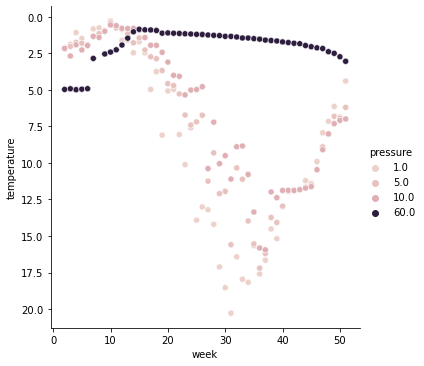

In [19]:
sns.relplot(data=metadata_bb, x="week", y="temperature", hue='pressure')

In [39]:
metadata_bb2 = metadata_bb.fillna(0)

In [40]:
metadata_bb2["week"] = pd.to_numeric(metadata_bb2["week"])

In [42]:
metadata_bb2["temperature"] = pd.to_numeric(metadata_bb2["temperature"])

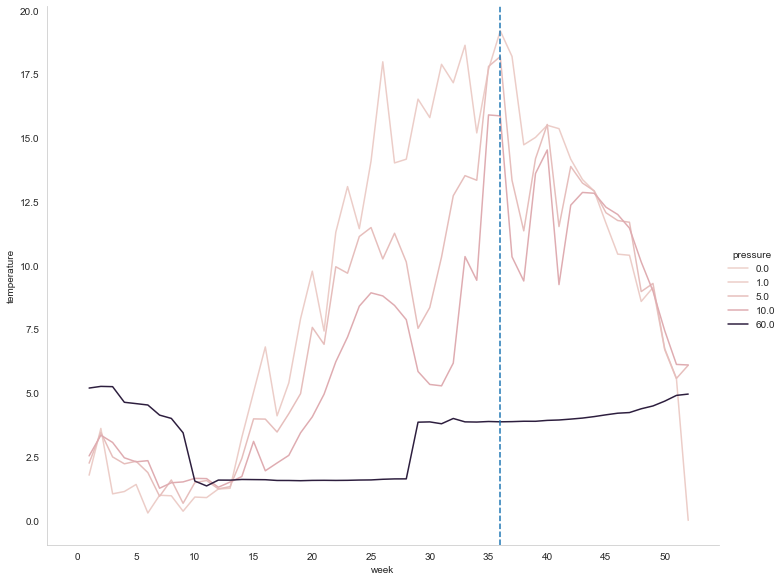

In [43]:
sns.set_style("whitegrid", {'axes.grid' : False})
g = sns.relplot(
    data=metadata_bb2, kind="line",
    x="week", y="temperature", hue="pressure", height = 8, aspect = 1.25
)
g.set(xticks=np.arange(0,52,5))
plt.axvline(36, ls='--')

In [22]:
metadata_bb

,sampleid,Year,Date,Week #,Correct Week #,Depth(m),Depth code,Size Code\n0.2um - S\n3um - L,Tube Label\nBBYear.WeekDepthSize,Extraction Date,...,altimeter,sigmaTheta2,VOLT,depth,fluorometer,par,flagArchaic,year,depth_code,week
0,BB19-2AL,2019.0,09-Jan,2.0,2.0,1.0,A,L,BB19-2AL,JAN 18 2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,2.0
1,BB19-2AS,2019.0,09-Jan,2.0,2.0,1.0,A,S,BB19-2AS,JAN 18 2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,2.0
2,BB19-2BL,2019.0,09-Jan,2.0,2.0,5.0,B,L,BB19-2BL,JAN 18 2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,B,2.0
3,BB19-2BS,2019.0,09-Jan,2.0,2.0,5.0,B,S,BB19-2BS,JAN 18 2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,B,2.0
4,BB19-2CL,2019.0,09-Jan,2.0,2.0,10.0,C,L,BB19-2CL,JAN 18 2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,C,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,BB19-51DS,2019.0,18-Dec,51.0,51.0,60.0,D,S,BB19-DEC18 DS,Dec 14 2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,D,51.0
402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,43.0
403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,D,43.0
404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,B,43.0


In [23]:
biomtable19 = pd.read_csv("/Users/Diana/Documents/escuela/phd/bb_data/2019/dada2_output_270210_exported/table_from_biom.txt", sep='\t')
classification = pd.read_csv("/Users/Diana/Documents/escuela/phd/bb_data/2019/taxa_270210/taxonomy.tsv", sep='\t')

In [63]:
biomtable14 = pd.read_csv("/Users/Diana/Documents/escuela/phd/bb_data/2014/dada2_output_exported/feature-table.tsv", sep='\t')
classification14 = pd.read_csv("/Users/Diana/Documents/escuela/phd/bb_data/2014/taxa/taxonomy.tsv", sep='\t')

In [64]:
biomtable14.rename({'#OTU ID': 'Feature ID'}, axis=1, inplace=True)

In [65]:
biomtable14

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,# Constructed from biom file
#OTU ID,BB14-10A,BB14-10B,BB14-10C,BB14-10D,BB14-11A,BB14-11B,BB14-11C,BB14-11D,BB14-12A,BB14-12B,BB14-12C,BB14-12D,BB14-13A,BB14-13B,BB14-13C,BB14-13D,BB14-14A,BB14-14B,BB14-14C,BB14-14D,BB14-15A,BB14-15B,BB14-15C,BB14-15D,BB14-16A,BB14-16B,BB14-16C,BB14-16D,BB14-17A,BB14-17B,BB14-17C,BB14-17D,BB14-18A,BB14-18B,BB14-18C,BB14-18D,BB14-19A,BB14-19B,BB14-19C,BB14-19D,BB14-20A,BB14-20B,BB14-20C,BB14-20D,BB14-21A,BB14-21B,BB14-21C,BB14-21D,BB14-22A,BB14-22B,BB14-22C,BB14-22D,BB14-23A,BB14-23B,BB14-23C,BB14-23D,BB14-24A,BB14-24B,BB14-24C,BB14-24D,BB14-25A,BB14-25B,BB14-25C,BB14-25D,BB14-26A,BB14-26B,BB14-26C,BB14-26D,BB14-27A,BB14-27B,BB14-27C,BB14-27D,BB14-28A,BB14-28B,BB14-28C,BB14-28D,BB14-29A,BB14-29B,BB14-29C,BB14-29D,BB14-30A,BB14-30B,BB14-30C,BB14-30D,BB14-31A,BB14-31B,BB14-31C,BB14-31D,BB14-32A,BB14-32B,BB14-32C,BB14-32D,BB14-33A,BB14-33B,BB14-33C,BB14-33D,BB14-34A,BB14-34B,BB14-34C,BB14-34D,BB14-35A,BB14-35B,BB14-35C,BB14-35D,BB14-36A,BB14-36B,BB14-36C,BB14-36D,BB14-37A,BB14-37B,BB14-37C,BB14-37D,BB14-38A,BB14-38B,BB14-38C,BB14-38D,BB14-39A,BB14-39B,BB14-39C,BB14-39D,BB14-3A,BB14-3B,BB14-3C,BB14-3D,BB14-40A,BB14-40B,BB14-40C,BB14-40D,BB14-41A,BB14-41B,BB14-41C,BB14-41D,BB14-42A,BB14-42B,BB14-42C,BB14-42D,BB14-43A,BB14-43B,BB14-43C,BB14-43D,BB14-44A,BB14-44B,BB14-44C,BB14-44D,BB14-45A,BB14-45B,BB14-45C,BB14-45D,BB14-46A,BB14-46B,BB14-46C,BB14-46D,BB14-47C,BB14-47D,BB14-48A,BB14-48B,BB14-48C,BB14-48D,BB14-49A,BB14-49B,BB14-49C,BB14-49D,BB14-4A,BB14-4B,BB14-4C,BB14-4D,BB14-50A,BB14-50B,BB14-50C,BB14-50D,BB14-51A,BB14-51B,BB14-51C,BB14-51D,BB14-5A,BB14-5B,BB14-5C,BB14-5D,BB14-6A,BB14-6B,BB14-6C,BB14-6D,BB14-7A,BB14-7B,BB14-7C,BB14-7D,BB14-8A,BB14-8B,BB14-8C,BB14-8D,BB14-9A,BB14-9B,BB14-9C,BB14-9D
79f3f51b584fe5e37cebc3b9f117c5ae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7012a87569ffdbc4422e4b6fe72ec59d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cbcffc3da0cc6ea7a5d6a9fee1713b2f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0

In [62]:
meltedbiom = pd.melt(frame=biomtable14, id_vars = 'Feature ID', var_name = 'sampleid', value_name = 'Rel Abun')

AttributeError: 'NoneType' object has no attribute 'columns'

In [27]:
mergedmelty = pd.merge(meltedbiom, classification, on = 'Feature ID',how='inner')

In [28]:
merged = mergedmelty.set_index('Taxon')

In [29]:
merged = merged.drop(columns=['Confidence', 'Feature ID'])

In [30]:
merged

,sampleid,Rel Abun
Taxon,,
d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Legionellales; f__Legionellaceae; g__Legionella; s__uncultured_Legionellaceae,BB19-18AL,0.0
d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Legionellales; f__Legionellaceae; g__Legionella; s__uncultured_Legionellaceae,BB19-18AS,0.0
d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Legionellales; f__Legionellaceae; g__Legionella; s__uncultured_Legionellaceae,BB19-18BL,0.0
d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Legionellales; f__Legionellaceae; g__Legionella; s__uncultured_Legionellaceae,BB19-18BS,0.0
d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Legionellales; f__Legionellaceae; g__Legionella; s__uncultured_Legionellaceae,BB19-18CL,0.0
...,...,...
d__Bacteria; p__Desulfobacterota; c__Desulfuromonadia; o__Bradymonadales; f__Bradymonadales; g__Bradymonadales; s__uncultured_marine,BB19-a43BS,0.0
d__Bacteria; p__Desulfobacterota; c__Desulfuromonadia; o__Bradymonadales; f__Bradymonadales; g__Bradymonadales; s__uncultured_marine,BB19-a43CL,0.0
d__Bacteria; p__Desulfobacterota; c__Desulfuromonadia; o__Bradymonadales; f__Bradymonadales; g__Bradymonadales; s__uncultured_marine,BB19-a43CS,0.0


In [31]:
merged.loc[:,'Total'] = merged.sum(axis=1)
merged

,sampleid,Rel Abun,Total
Taxon,,,
d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Legionellales; f__Legionellaceae; g__Legionella; s__uncultured_Legionellaceae,BB19-18AL,0.0,0.0
d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Legionellales; f__Legionellaceae; g__Legionella; s__uncultured_Legionellaceae,BB19-18AS,0.0,0.0
d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Legionellales; f__Legionellaceae; g__Legionella; s__uncultured_Legionellaceae,BB19-18BL,0.0,0.0
d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Legionellales; f__Legionellaceae; g__Legionella; s__uncultured_Legionellaceae,BB19-18BS,0.0,0.0
d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Legionellales; f__Legionellaceae; g__Legionella; s__uncultured_Legionellaceae,BB19-18CL,0.0,0.0
...,...,...,...
d__Bacteria; p__Desulfobacterota; c__Desulfuromonadia; o__Bradymonadales; f__Bradymonadales; g__Bradymonadales; s__uncultured_marine,BB19-a43BS,0.0,0.0
d__Bacteria; p__Desulfobacterota; c__Desulfuromonadia; o__Bradymonadales; f__Bradymonadales; g__Bradymonadales; s__uncultured_marine,BB19-a43CL,0.0,0.0
d__Bacteria; p__Desulfobacterota; c__Desulfuromonadia; o__Bradymonadales; f__Bradymonadales; g__Bradymonadales; s__uncultured_marine,BB19-a43CS,0.0,0.0


In [32]:
groupedbytaxon = merged.groupby(['Taxon']).sum()

In [33]:
groupformelty = groupedbytaxon.reset_index()

In [34]:
totals = groupformelty[['Taxon', 'Total']]

In [35]:
top20 = groupedbytaxon.nlargest(20,'Total')

In [36]:
top5 = groupedbytaxon.nlargest(5, 'Total')

In [37]:
rare5 =  groupedbytaxon.nsmallest(5, 'Total')

In [38]:
rare5.index

Index(['d__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Chitinophagales; f__uncultured; g__uncultured; s__uncultured_delta',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Cytophagales; f__Cyclobacteriaceae; g__Fulvivirga; s__uncultured_Flexibacter',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Cytophagales; f__Spirosomaceae; g__Arcicella',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Crocinitomicaceae; g__uncultured; s__uncultured_Bacteroidetes',
       'd__Bacteria; p__Desulfobacterota; c__Desulfuromonadia; o__Desulfuromonadia; f__Geopsychrobacteraceae; g__Desulfuromusa; s__uncultured_bacterium'],
      dtype='object', name='Taxon')

In [39]:
top20 = top20.drop(columns=['Total'])

In [40]:
top20T = top20.T
top20T['sampleid'] = top20T.index

In [41]:
top20T.columns

Index(['d__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Chitinophagales; f__Saprospiraceae; g__Lewinella; s__uncultured_marine',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Planktomarina',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Oceanospirillales; f__Nitrincolaceae; g__uncultured; s__uncultured_marine',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__SAR11_clade; f__Clade_I; g__Clade_Ia',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Thiomicrospirales; f__Thioglobaceae',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Amylibacter',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Crocinitomicaceae; g__Fluviicola',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidi

In [42]:
df_long.pivot_table(index=["sampleid"], 
                    columns='class', 
                    values='grade')

NameError: name 'df_long' is not defined

In [43]:
df_long.pivot_table(index=["student", "school"], 
                    columns='class', 
                    values='grade')

NameError: name 'df_long' is not defined

In [44]:
withmeta = pd.merge(top20T, metadata_bb, on = 'sampleid',how='inner')

In [45]:
withmetamelty = pd.merge(mergedmelty, metadata_bb, on='sampleid', how='inner')

In [46]:
withmetamelty = pd.merge (withmetamelty, totals, on = 'Taxon', how='inner')

In [47]:
withmetamelty

,Feature ID,sampleid,Rel Abun,Taxon,Confidence,Year,Date,Week #,Correct Week #,Depth(m),...,sigmaTheta2,VOLT,depth,fluorometer,par,flagArchaic,year,depth_code,week,Total
0,88504ccccf908bd07cad252b49564924,BB19-18AL,0.0,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.939373,2019.0,01-May,18.0,18.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,18.0,159.0
1,88504ccccf908bd07cad252b49564924,BB19-18AS,0.0,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.939373,2019.0,01-May,18.0,18.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,18.0,159.0
2,88504ccccf908bd07cad252b49564924,BB19-18BL,0.0,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.939373,2019.0,01-May,18.0,18.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,B,18.0,159.0
3,88504ccccf908bd07cad252b49564924,BB19-18BS,0.0,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.939373,2019.0,01-May,18.0,18.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,B,18.0,159.0
4,88504ccccf908bd07cad252b49564924,BB19-18CL,0.0,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.939373,2019.0,01-May,18.0,18.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,C,18.0,159.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701605,250a576e3788b3f444938c7b08afb2e3,BB19-a43BS,0.0,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.723322,2019.0,23-Oct,42.0,43.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,B,42.0,194.0
701606,250a576e3788b3f444938c7b08afb2e3,BB19-a43CL,0.0,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.723322,2019.0,23-Oct,42.0,43.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,C,42.0,194.0
701607,250a576e3788b3f444938c7b08afb2e3,BB19-a43CS,0.0,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.723322,2019.0,23-Oct,42.0,43.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,C,42.0,194.0
701608,250a576e3788b3f444938c7b08afb2e3,BB19-a43DL,0.0,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.723322,2019.0,23-Oct,42.0,43.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,D,42.0,194.0


In [48]:
top20 = ['d__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Chitinophagales; f__Saprospiraceae; g__Lewinella; s__uncultured_marine',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Planktomarina',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Oceanospirillales; f__Nitrincolaceae; g__uncultured; s__uncultured_marine',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__SAR11_clade; f__Clade_I; g__Clade_Ia',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Thiomicrospirales; f__Thioglobaceae',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Amylibacter',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Crocinitomicaceae; g__Fluviicola',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Flavobacteriaceae; g__uncultured; s__uncultured_marine',
       'd__Bacteria; p__Planctomycetota; c__OM190; o__OM190; f__OM190; g__OM190; s__marine_metagenome',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Thiomicrospirales; f__Thioglobaceae; g__SUP05_cluster',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Cryomorphaceae; g__uncultured',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Flavobacteriaceae',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Flavobacteriaceae; g__Tenacibaculum',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Flavobacteriaceae; g__Ulvibacter; s__uncultured_marine',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Flavobacteriaceae; g__NS5_marine_group',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Flavobacteriaceae; g__Polaribacter',
       'd__Bacteria; p__Nitrospinota; c__Nitrospinia; o__Nitrospinales; f__Nitrospinaceae; g__LS-NOB',
       'd__Bacteria; p__Planctomycetota; c__Planctomycetes; o__Planctomycetales; f__Rubinisphaeraceae; g__Fuerstia; s__uncultured_bacterium',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Flavobacteriaceae; g__NS3a_marine_group']


In [49]:
top5 = ['d__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Chitinophagales; f__Saprospiraceae; g__Lewinella; s__uncultured_marine',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Planktomarina',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Oceanospirillales; f__Nitrincolaceae; g__uncultured; s__uncultured_marine',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__SAR11_clade; f__Clade_I; g__Clade_Ia',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Thiomicrospirales; f__Thioglobaceae']

In [50]:
mdtop20 = withmetamelty[withmetamelty['Taxon'].isin(top20)]

In [51]:
mdtop5 = withmetamelty[withmetamelty['Taxon'].isin(top5)]

In [44]:
sns.set_style("whitegrid", {'axes.grid' : False})
g = sns.relplot(
    data=mdtop5, kind="line",
    x="week", y="Rel Abun", hue="Taxon", height = 8, aspect = 1.25
)
g.set(xticks=np.arange(0,52,5))
plt.axvline(36, ls='--')

NameError: name 'mdtop5' is not defined

In [53]:
mdtop5

,Feature ID,sampleid,Rel Abun,Taxon,Confidence,Year,Date,Week #,Correct Week #,Depth(m),...,sigmaTheta2,VOLT,depth,fluorometer,par,flagArchaic,year,depth_code,week,Total
169260,8de78294559168d41a2f0ec6196bff4f,BB19-18AL,73.0,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.704028,2019.0,01-May,18.0,18.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,18.0,312112.0
169261,2462a5acc546029c7e21fd170d2a482e,BB19-18AL,0.0,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.771751,2019.0,01-May,18.0,18.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,18.0,312112.0
169262,51d6f4fcbee32cc1382a4e8a147f384e,BB19-18AL,0.0,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.729820,2019.0,01-May,18.0,18.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,18.0,312112.0
169263,f752e67ebf6c52d40f99164cef71911e,BB19-18AL,0.0,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.787688,2019.0,01-May,18.0,18.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,18.0,312112.0
169264,6339c9fdaf957a8ba7073ab06e76f910,BB19-18AL,0.0,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.757582,2019.0,01-May,18.0,18.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,18.0,312112.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493306,fa31e148a4fa1a4dfce3b59a2d542b85,BB19-a43DL,8.0,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.735284,2019.0,23-Oct,42.0,43.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,D,42.0,400813.0
493307,71a33c961f2ca92f6ce97184fcb81f01,BB19-a43DL,914.0,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.999488,2019.0,23-Oct,42.0,43.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,D,42.0,400813.0
493308,a897667502a072da9c30e63c34547778,BB19-a43DS,0.0,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.980163,2019.0,23-Oct,42.0,43.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,D,42.0,400813.0
493309,fa31e148a4fa1a4dfce3b59a2d542b85,BB19-a43DS,0.0,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.735284,2019.0,23-Oct,42.0,43.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,D,42.0,400813.0


In [54]:
metadata_bb

,sampleid,Year,Date,Week #,Correct Week #,Depth(m),Depth code,Size Code\n0.2um - S\n3um - L,Tube Label\nBBYear.WeekDepthSize,Extraction Date,...,altimeter,sigmaTheta2,VOLT,depth,fluorometer,par,flagArchaic,year,depth_code,week
0,BB19-2AL,2019.0,09-Jan,2.0,2.0,1.0,A,L,BB19-2AL,JAN 18 2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,2.0
1,BB19-2AS,2019.0,09-Jan,2.0,2.0,1.0,A,S,BB19-2AS,JAN 18 2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,2.0
2,BB19-2BL,2019.0,09-Jan,2.0,2.0,5.0,B,L,BB19-2BL,JAN 18 2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,B,2.0
3,BB19-2BS,2019.0,09-Jan,2.0,2.0,5.0,B,S,BB19-2BS,JAN 18 2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,B,2.0
4,BB19-2CL,2019.0,09-Jan,2.0,2.0,10.0,C,L,BB19-2CL,JAN 18 2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,C,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,BB19-51DS,2019.0,18-Dec,51.0,51.0,60.0,D,S,BB19-DEC18 DS,Dec 14 2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,D,51.0
402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,43.0
403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,D,43.0
404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB19,B,43.0


In [187]:
mdtop5.pressure.unique()

array([ 1.,  5., 10., 60., nan])

In [186]:
mdtop5['pressure'] = mdtop5['pressure'].replace('nan', 0.0)

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [194]:
mdtop5_dA = mdtop5[mdtop5.depth_code == 'A']

In [195]:
fig = px.line(mdtop5_dA, x="week", y="Rel Abun", color='Taxon')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [203]:
fig = px.scatter(mdtop5_dA, x="week", y="temperature", color='Season')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [204]:
fig = px.scatter(mdtop5_dA, x="week", y="oxygen", color='Season')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [198]:
mdtop5_dA

,Feature ID,sampleid,Rel Abun,Taxon,Confidence,Year,Date,Week #,Correct Week #,Depth(m),...,sigmaTheta2,VOLT,depth,fluorometer,par,flagArchaic,year,depth_code,week,Total
169260,8de78294559168d41a2f0ec6196bff4f,BB19-18AL,73.0,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.704028,2019.0,01-May,18.0,18.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,18.0,312112.0
169261,2462a5acc546029c7e21fd170d2a482e,BB19-18AL,0.0,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.771751,2019.0,01-May,18.0,18.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,18.0,312112.0
169262,51d6f4fcbee32cc1382a4e8a147f384e,BB19-18AL,0.0,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.729820,2019.0,01-May,18.0,18.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,18.0,312112.0
169263,f752e67ebf6c52d40f99164cef71911e,BB19-18AL,0.0,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.787688,2019.0,01-May,18.0,18.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,18.0,312112.0
169264,6339c9fdaf957a8ba7073ab06e76f910,BB19-18AL,0.0,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.757582,2019.0,01-May,18.0,18.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,18.0,312112.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493288,fa31e148a4fa1a4dfce3b59a2d542b85,BB19-a43AL,0.0,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.735284,2019.0,23-Oct,42.0,43.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,42.0,400813.0
493289,71a33c961f2ca92f6ce97184fcb81f01,BB19-a43AL,4507.0,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.999488,2019.0,23-Oct,42.0,43.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,42.0,400813.0
493290,a897667502a072da9c30e63c34547778,BB19-a43AS,0.0,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.980163,2019.0,23-Oct,42.0,43.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,42.0,400813.0
493291,fa31e148a4fa1a4dfce3b59a2d542b85,BB19-a43AS,0.0,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.735284,2019.0,23-Oct,42.0,43.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,BB19,A,42.0,400813.0


In [201]:
withmetamelty.to_csv('w_md_melted.csv', index=False)

In [68]:
withmeta.columns

Index(['d__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Chitinophagales; f__Saprospiraceae; g__Lewinella; s__uncultured_marine',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Planktomarina',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Oceanospirillales; f__Nitrincolaceae; g__uncultured; s__uncultured_marine',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__SAR11_clade; f__Clade_I; g__Clade_Ia',
       'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Thiomicrospirales; f__Thioglobaceae',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae; g__Amylibacter',
       'd__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Flavobacteriales; f__Crocinitomicaceae; g__Fluviicola',
       'd__Bacteria; p__Bacteroidota; c__Bacteroidi